# Wifind Data - Final Analysis 

## Author_: Chritstian Rosado

In [324]:
# importing packages 
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
import shapely as shp
import seaborn 
import os
import geopandas as gpd
import statsmodels.api as sm
import scipy
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# important all data
startdate = "06/01/2017"
enddate = "07/24/2017"
link = 'http://wifindproject.com/wifipulling/?columns=lat%7Clng%7Cssid%7Cbssid%7Cacc%7Ctime%7Clevel\
&startdate={0}&enddate={1}&timeformat=1'.format(startdate,enddate)
print(link)

http://wifindproject.com/wifipulling/?columns=lat%7Clng%7Cssid%7Cbssid%7Cacc%7Ctime%7Clevel&startdate=06/01/2017&enddate=07/24/2017&timeformat=1


In [6]:
# loading raw data for analysis 
data = pd.read_json(link, dtype={"lng":float, "lat":float})

In [7]:
data.shape

(1354666, 7)

In [8]:
# filtering errant scans 
wifi_data = data.drop(data[data.acc > 50].index)

In [9]:
wifi_data.head(1)

,acc,bssid,lat,level,lng,ssid,time
0,19.929,fc:0a:81:c0:b4:b2,40.710426,-54.0,-74.011387,,06-12-2017 15:51:03


In [10]:
wifi_data.shape

(1299763, 7)

In [11]:
# errant resords removed
errant_records = data.shape[0] - wifi_data.shape[0]
print("number of errant records removed:", errant_records)

number of errant records removed: 54903


In [12]:
wifi_data.to_csv("wifi_data.csv")

In [13]:
wifi_data[["acc", "level"]].describe()

,acc,level
count,1.299763e+06,1.299763e+06
mean,1.500186e+01,-7.774415e+01
std,9.905865e+00,1.007554e+01
min,3.000000e+00,-9.900000e+01
25%,9.102000e+00,-8.600000e+01
50%,1.200000e+01,-7.900000e+01
75%,1.972100e+01,-7.100000e+01
max,5.000000e+01,-1.000000e+01


In [14]:
# generating points for wifi data
def points(p):
    point = shp.geometry.Point(p)
    return point

wifi_data["geometry"] = list(map(lambda x: points(x), zip(wifi_data.lng, wifi_data.lat)))

In [15]:
wifi_data.head(1)

,acc,bssid,lat,level,lng,ssid,time,geometry
0,19.929,fc:0a:81:c0:b4:b2,40.710426,-54.0,-74.011387,,06-12-2017 15:51:03,POINT (-74.01138659999999 40.7104258)


In [16]:
wifi_data.to_csv("wifi_data_v2.csv")

In [17]:
wifi_data.shape

(1299763, 8)

In [18]:
# loading wifi data into geopandas
wifi_shape = gpd.GeoDataFrame(wifi_data)

In [19]:
#housing_shape = gpd.GeoDataFrame.from_file("../Downloads/data/shape/Export_Output.shp")

In [20]:
# loading census block groups shapes into geopandas
housing_shape = gpd.GeoDataFrame.from_file("../Downloads/data/tl_2013_36_bg/tl_2013_36_bg.shp")

In [21]:
housing_shape.shape

(15463, 13)

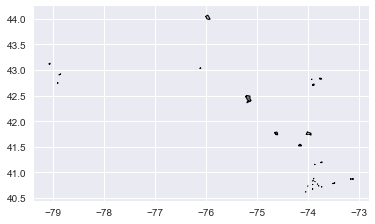

In [20]:
housing_shape[::500].plot()

In [22]:
# epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
wifi_shape.crs = from_epsg(4326)
housing_shape.crs = from_epsg(4326)

In [23]:
# merging wifi data with housing shapes - blocks 
# geometry = points
#housing_wifi = gpd.sjoin(wifi_shape, housing_shape, how="inner", op='intersects') #geo merger

In [24]:
# merging wifi data with housing shapes - blocks 
# geometry = polygons
housing_wifi_ = gpd.sjoin(housing_shape, wifi_shape, how="inner", op='intersects') #geo merger

In [25]:
housing_shape.shape

(15463, 13)

In [26]:
housing_wifi_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,TRACTCE,geometry,index_right,acc,bssid,lat,level,lng,ssid,time
1942,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,001501,"POLYGON ((-74.00861399999999 40.711372, -74.00...",881088,50.0,fc:0a:81:b5:ee:c2,40.710642,-77.0,-74.008483,,07-10-2017 19:47:26


In [27]:
uni_bssid = housing_wifi_.groupby(housing_wifi_.GEOID)['bssid'].nunique()

In [28]:
uni_bssid = pd.DataFrame(uni_bssid)

In [29]:
uni_bssid["GEOID"] = uni_bssid.index
uni_bssid["uni_bssid_count"] = uni_bssid.bssid

In [30]:
del uni_bssid["bssid"]

In [31]:
uni_bssid.head()

,GEOID,uni_bssid_count
GEOID,,
360470001004,360470001004,9
360470003014,360470003014,306
360470005013,360470005013,251
360470005022,360470005022,214
360470007001,360470007001,562


In [32]:
# merge unique bssid with main data frame
housing_wifi__uni = housing_wifi_.merge(uni_bssid, on="GEOID", how="inner")

In [33]:
housing_wifi__uni.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,geometry,index_right,acc,bssid,lat,level,lng,ssid,time,uni_bssid_count
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,"POLYGON ((-74.00861399999999 40.711372, -74.00...",881088,50.0,fc:0a:81:b5:ee:c2,40.710642,-77.0,-74.008483,,07-10-2017 19:47:26,24


In [34]:
housing_wifi__uni.shape

(1293182, 22)

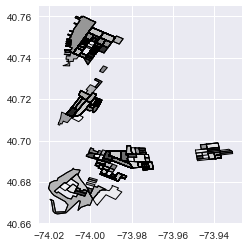

In [35]:
housing_wifi__uni[::1000].plot()

In [36]:
# Merge Population and median household income Data for blocks groups

In [37]:
# genrate bar chart, t-test, and plot median household income vs. bssid/population

# Loading Demographic Data - Population, MHI, and Education (if possible)

# Income

In [38]:
# merge income data

In [39]:
census_block_group_income = pd.read_csv("../Downloads/data/census_block_group_income.csv", converters={"Geo_FIPS":str})

In [40]:
census_block_group_income["GEOID"] = census_block_group_income.Geo_FIPS
del census_block_group_income["Geo_FIPS"]
census_block_group_income["MHI"] = census_block_group_income.SE_T093_001
del census_block_group_income["SE_T093_001"]

In [41]:
census_block_group_income.head(1)

,Geo_NAME,Geo_QName,Geo_AREALAND,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,Geo_TRACT,Geo_BLKGRP,GEOID,MHI
0,Block Group 1,"Block Group 1, Census Tract 1, Albany County, ...",2005713,235376,150,0,1,2,36,1,100,1,360010001001,24615


In [42]:
census_block_group_income.shape

(15079, 14)

In [43]:
#census_block_group_income["block_group"], census_block_group_income["census_tract"], \
#census_block_group_income["county"], census_block_group_income["state"] = \
#census_block_group_income.Geo_QName.str.split(',').str

In [44]:
#census_block_group_income["block_group"] = census_block_group_income["block_group"].str.split(' ').str[2]
#census_block_group_income["block_group"] = 

In [45]:
#census_block_group_income["census_tract"] = census_block_group_income["census_tract"].str.split(' ').str[3]
#census_block_group_income["census_tract"] =

In [46]:
#census_block_group_income[census_block_group_income.county.str.contains("Richmond County")]

In [47]:
housing_wifi__uni.GEOID.dtype

dtype('O')

In [48]:
census_block_group_income.GEOID.dtype

dtype('O')

In [49]:
housing_wifi_uni_by_bl_group = housing_wifi__uni.merge(census_block_group_income, on="GEOID", how="inner")

In [50]:
housing_wifi_uni_by_bl_group.shape

(1123257, 35)

In [51]:
housing_wifi_uni_by_bl_group.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,Geo_TRACT,Geo_BLKGRP,MHI
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
1,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
2,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
3,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
4,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232


In [52]:
housing_wifi_uni_by_bl_group.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'index_right', 'acc', 'bssid', 'lat', 'level', 'lng',
       'ssid', 'time', 'uni_bssid_count', 'Geo_NAME', 'Geo_QName',
       'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV', 'Geo_GEOCOMP',
       'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY', 'Geo_TRACT',
       'Geo_BLKGRP', 'MHI'],
      dtype='object')

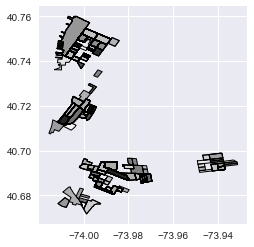

In [53]:
housing_wifi_uni_by_bl_group[::1000].plot()

# Population

In [54]:
# merge population 

In [55]:
# Loading population data by block group
census_block_group_pop = pd.read_csv("../Downloads/data/census_block_group_pop.csv", converters={"Geo_FIPS":str})

In [56]:
census_block_group_pop["GEOID"] = census_block_group_pop.Geo_FIPS
del census_block_group_pop["Geo_FIPS"]
census_block_group_pop["Population"] = census_block_group_pop.SE_T003_002
del census_block_group_pop["SE_T003_002"]
census_block_group_pop["Pop_Density"] = census_block_group_pop.SE_T003_001
del census_block_group_pop["SE_T003_001"]

In [57]:
census_block_group_pop.head(1)

,Geo_NAME,Geo_QName,Geo_AREALAND,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,Geo_TRACT,Geo_BLKGRP,SE_T003_003,GEOID,Population,Pop_Density
0,Block Group 1,"Block Group 1, Census Tract 1, Albany County, ...",2005713,235376,150,0,1,2,36,1,100,1,0.77441,360010001001,1031,1331.336


In [58]:
housing_wifi_uni_by_bl_group.GEOID.dtype

dtype('O')

In [59]:
census_block_group_pop.GEOID.dtype

dtype('O')

In [60]:
housing_wifi_uni_by_bl_group_ = housing_wifi_uni_by_bl_group.merge(census_block_group_pop, on="GEOID", how="inner")

In [61]:
housing_wifi_uni_by_bl_group_.shape

(1123257, 50)

In [62]:
housing_wifi_uni_by_bl_group_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Geo_GEOCOMP_y,Geo_REGION_y,Geo_DIVISION_y,Geo_STATE_y,Geo_COUNTY_y,Geo_TRACT_y,Geo_BLKGRP_y,SE_T003_003,Population,Pop_Density
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,1,2,36,61,1501,1,0.040587,3552,87515.58


In [63]:
housing_wifi_uni_by_bl_group_.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'index_right', 'acc', 'bssid', 'lat', 'level', 'lng',
       'ssid', 'time', 'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x',
       'Geo_AREALAND_x', 'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x',
       'Geo_REGION_x', 'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x',
       'Geo_TRACT_x', 'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y',
       'Geo_AREALAND_y', 'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y',
       'Geo_REGION_y', 'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y',
       'Geo_TRACT_y', 'Geo_BLKGRP_y', 'SE_T003_003', 'Population',
       'Pop_Density'],
      dtype='object')

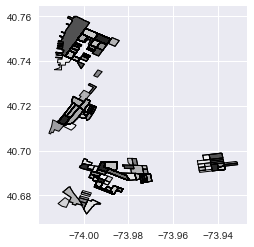

In [64]:
housing_wifi_uni_by_bl_group_[::1000].plot()

# Education

In [64]:
# merge education

In [65]:
# Loading education data by block group
census_block_group_edu = pd.read_csv("../Downloads/data/education_attainment.csv", converters={"Geo_FIPS":str})

In [66]:
census_block_group_edu["GEOID"] = census_block_group_edu.Geo_FIPS
del census_block_group_edu["Geo_FIPS"]
census_block_group_edu["Pop_over_25"] = census_block_group_edu.SE_T040_001
del census_block_group_edu["SE_T040_001"]
census_block_group_edu["Less_than_HS"] = census_block_group_edu.SE_T040_002
del census_block_group_edu["SE_T040_002"]
census_block_group_edu["High_School"] = census_block_group_edu.SE_T040_003
del census_block_group_edu["SE_T040_003"]
census_block_group_edu["Some_College"] = census_block_group_edu.SE_T040_004
del census_block_group_edu["SE_T040_004"]
census_block_group_edu["Bachelors"] = census_block_group_edu.SE_T040_005
del census_block_group_edu["SE_T040_005"]
census_block_group_edu["Masters"] = census_block_group_edu.SE_T040_006
del census_block_group_edu["SE_T040_006"]
census_block_group_edu["Professional_School_Degree"] = census_block_group_edu.SE_T040_007
del census_block_group_edu["SE_T040_007"]
census_block_group_edu["Doctorate"] = census_block_group_edu.SE_T040_008
del census_block_group_edu["SE_T040_008"]

In [67]:
census_block_group_edu.head(1)

,Geo_NAME,Geo_QName,Geo_AREALAND,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,...,Geo_BLKGRP,GEOID,Pop_over_25,Less_than_HS,High_School,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate
0,Block Group 1,"Block Group 1, Census Tract 1, Albany County, ...",2005713,235376,150,0,1,2,36,1,...,1,360010001001,685,198,181,222,62,15,7,0


In [68]:
housing_wifi_uni_by_bl_group_.GEOID.dtype

dtype('O')

In [69]:
census_block_group_edu.GEOID.dtype

dtype('O')

In [70]:
housing_wifi_uni_by_bl_group__ = housing_wifi_uni_by_bl_group_.merge(census_block_group_edu, on="GEOID", how="inner")

In [71]:
housing_wifi_uni_by_bl_group__.shape

(1123257, 70)

In [72]:
housing_wifi_uni_by_bl_group__.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Geo_TRACT,Geo_BLKGRP,Pop_over_25,Less_than_HS,High_School,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,1501,1,3032,408,709,730,830,238,97,20


In [73]:
housing_wifi_uni_by_bl_group__.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'index_right', 'acc', 'bssid', 'lat', 'level', 'lng',
       'ssid', 'time', 'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x',
       'Geo_AREALAND_x', 'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x',
       'Geo_REGION_x', 'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x',
       'Geo_TRACT_x', 'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y',
       'Geo_AREALAND_y', 'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y',
       'Geo_REGION_y', 'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y',
       'Geo_TRACT_y', 'Geo_BLKGRP_y', 'SE_T003_003', 'Population',
       'Pop_Density', 'Geo_NAME', 'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR',
       'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE',
       'Geo_COUNTY', 'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS',
       'High_School', 'Some_College',

In [74]:
del housing_wifi_uni_by_bl_group__["index_right"]

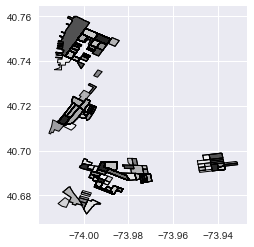

In [77]:
housing_wifi_uni_by_bl_group__[::1000].plot()

# Loading 10 Areas

In [75]:
# loading housing projects areas shapes into geopandas (10)
housing_areas_shape = gpd.GeoDataFrame.from_file("../Downloads/data/Ranges_new/Ranges.shp")

In [76]:
housing_areas_shape.head(1)

,cartodb_id,descriptio,geometry,name
0,8,,"POLYGON ((-74.00246859000001 40.6730546, -74.0...",Public_RedHook


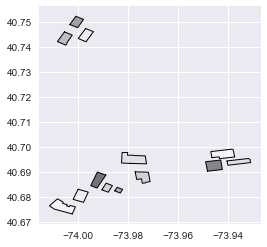

In [80]:
housing_areas_shape.plot()

In [77]:
housing_areas_shape.crs = from_epsg(4326)

In [78]:
housing_gdf = gpd.sjoin(housing_wifi_uni_by_bl_group__, housing_areas_shape, how="inner", op='within')

In [79]:
# 422365
housing_gdf.shape

(450638, 73)

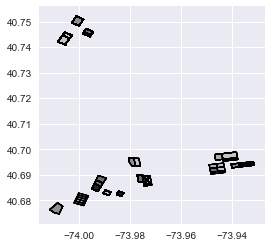

In [80]:
housing_gdf[::100].plot()

In [81]:
housing_gdf.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'acc', 'bssid', 'lat', 'level', 'lng', 'ssid', 'time',
       'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x', 'Geo_AREALAND_x',
       'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x', 'Geo_REGION_x',
       'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x', 'Geo_TRACT_x',
       'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y', 'Geo_AREALAND_y',
       'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y', 'Geo_REGION_y',
       'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y', 'Geo_TRACT_y',
       'Geo_BLKGRP_y', 'SE_T003_003', 'Population', 'Pop_Density', 'Geo_NAME',
       'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS', 'High_School',
       'Some_College', 'Bachelors', '

In [82]:
pd.DataFrame(housing_gdf.name.unique(), columns=["Areas"])

,Areas
0,Public_RedHook
1,Non_Public_RedHook
2,Public_Whitman
3,Public_Gowanus
4,Public_Chelsea
5,Non_Public_Tompkins
6,Non_Public_Gowanus
7,Public_Tompkins
8,Non_Public_Chelsea
9,Non_Public_Whitman


In [83]:
housing_gdf.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,High_School,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate,index_right,cartodb_id,descriptio,name
995019,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,947,649,79,50,0,0,0,8,,Public_RedHook
995020,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,947,649,79,50,0,0,0,8,,Public_RedHook
995021,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,947,649,79,50,0,0,0,8,,Public_RedHook
995022,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,947,649,79,50,0,0,0,8,,Public_RedHook
995023,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,947,649,79,50,0,0,0,8,,Public_RedHook


# Targeted Areas

In [84]:
area_populations = housing_gdf.groupby(["name"])["Population"].unique()

In [85]:
area_populations = pd.DataFrame(area_populations)

In [86]:
area_populations

,Population
name,
Non_Public_Chelsea,"[1723, 911]"
Non_Public_Gowanus,"[733, 848, 825]"
Non_Public_RedHook,"[761, 729, 692, 625, 570]"
Non_Public_Tompkins,"[1091, 584, 613, 1026, 1131]"
Non_Public_Whitman,"[780, 853, 410, 571]"
Public_Chelsea,"[1546, 1479, 1260]"
Public_Gowanus,"[3221, 957]"
Public_RedHook,[7278]
Public_Tompkins,"[3595, 1641, 2921, 1305, 1135, 1600]"


In [87]:
area_populations["Population"] = list(map(lambda x: x[0].sum(),area_populations.Population))

In [88]:
area_populations

,Population
name,
Non_Public_Chelsea,1723
Non_Public_Gowanus,733
Non_Public_RedHook,761
Non_Public_Tompkins,1091
Non_Public_Whitman,780
Public_Chelsea,1546
Public_Gowanus,3221
Public_RedHook,7278
Public_Tompkins,3595


In [89]:
area_populations["name"] = area_populations.index

In [90]:
#area_populations = housing_gdf.groupby(["name","GEOID"])["Population"].unique()

In [91]:
area_populations

,Population,name
name,,
Non_Public_Chelsea,1723,Non_Public_Chelsea
Non_Public_Gowanus,733,Non_Public_Gowanus
Non_Public_RedHook,761,Non_Public_RedHook
Non_Public_Tompkins,1091,Non_Public_Tompkins
Non_Public_Whitman,780,Non_Public_Whitman
Public_Chelsea,1546,Public_Chelsea
Public_Gowanus,3221,Public_Gowanus
Public_RedHook,7278,Public_RedHook
Public_Tompkins,3595,Public_Tompkins


In [92]:
area_populations.shape

(10, 2)

In [93]:
housing_gdf.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'acc', 'bssid', 'lat', 'level', 'lng', 'ssid', 'time',
       'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x', 'Geo_AREALAND_x',
       'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x', 'Geo_REGION_x',
       'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x', 'Geo_TRACT_x',
       'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y', 'Geo_AREALAND_y',
       'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y', 'Geo_REGION_y',
       'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y', 'Geo_TRACT_y',
       'Geo_BLKGRP_y', 'SE_T003_003', 'Population', 'Pop_Density', 'Geo_NAME',
       'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS', 'High_School',
       'Some_College', 'Bachelors', '

In [94]:
unique_bssid = housing_gdf.groupby(housing_gdf.name)["bssid"].nunique()

In [95]:
df = pd.DataFrame(unique_bssid)

In [96]:
df["name"] = df.index

In [97]:
df["uni_bssid_by_housing_area"] = df.bssid

In [98]:
del df["bssid"]

In [99]:
df

,name,uni_bssid_by_housing_area
name,,
Non_Public_Chelsea,Non_Public_Chelsea,2172
Non_Public_Gowanus,Non_Public_Gowanus,1065
Non_Public_RedHook,Non_Public_RedHook,867
Non_Public_Tompkins,Non_Public_Tompkins,1515
Non_Public_Whitman,Non_Public_Whitman,3666
Public_Chelsea,Public_Chelsea,5774
Public_Gowanus,Public_Gowanus,1628
Public_RedHook,Public_RedHook,448
Public_Tompkins,Public_Tompkins,3134


In [100]:
housing_gdf_ = housing_gdf.merge(df, on="name")

In [101]:
housing_gdf_.shape

(450638, 74)

In [102]:
housing_gdf_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate,index_right,cartodb_id,descriptio,name,uni_bssid_by_housing_area
0,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,649,79,50,0,0,0,8,,Public_RedHook,448


# Indentifying Open Networks

In [103]:
def open_net(x):
    x = str(x).lower()
    free_wifi_list = ["flatiron free wifi","flatiron","freewifibysurface","bryantpark.org","bryantpark",\
                     "downtownbrooklynwifi_fon","downtownbrooklyn","linknyc free wi-fi","linknyc","metrotech",\
                     "usp park wifi","usppark","red hook wifi","redhook","attwifi","guestwifi","guest",\
                      "unionsquarewifi"]
    for free_wifi in free_wifi_list:
        if x in free_wifi:
            return True
        else:
            return False

In [104]:
def open_net(x):
    x = str(x)
    if "flatiron free wifi" in x.lower():
        return True
    else:
        if "flatiron" in x.lower():
            return True
        else:
            if "freewifibysurface" in x.lower():
                return True
            else:
                if "bryantpark.org" in x.lower():
                    return True
                else:
                    if "bryantpark" in x.lower():
                        return True
                    else:
                        if "downtownbrooklynwifi_fon" in x.lower():
                            return True
                        else:
                            if "downtownbrooklyn" in x.lower():
                                return True
                            else:
                                if "linknyc free wi-fi" in x.lower():
                                    return True
                                else:
                                    if "linknyc" in x.lower():
                                        return True
                                    else:
                                        if "metrotech" in x.lower():
                                            return True
                                        else:
                                            if "usp park wifi" in x.lower():
                                                return True
                                            else:
                                                if "usppark" in x.lower():
                                                    return True
                                                else: 
                                                    if "red hook wifi" in x.lower():
                                                        return True
                                                    else:
                                                        if "redhook" in x.lower():
                                                            return True
                                                        else:
                                                            if "attwifi" in x.lower():
                                                                return True
                                                            else:
                                                                if "guestwifi" in x.lower():
                                                                    return True
                                                                else:
                                                                    if "guest" in x.lower():
                                                                        return True
                                                                    else:
                                                                        if "unionsquarewifi" in x.lower():
                                                                            return True
                                                                        else:
                                                                            return False

In [105]:
open_net("guest")

True

In [106]:
housing_gdf_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate,index_right,cartodb_id,descriptio,name,uni_bssid_by_housing_area
0,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,649,79,50,0,0,0,8,,Public_RedHook,448


In [107]:
#del housing_gdf_["open_net"]

In [108]:
housing_gdf_["open_net"] = list(map(lambda x: open_net(x), housing_gdf_.ssid))

In [109]:
housing_gdf_["open_net"].describe()

count     450638
unique         2
top        False
freq      431950
Name: open_net, dtype: object

In [110]:
networks = pd.DataFrame(housing_gdf_["ssid"].unique())

In [111]:
housing_gdf_.groupby(housing_gdf_.name)["open_net"].sum()

name
Non_Public_Chelsea      3462.0
Non_Public_Gowanus       798.0
Non_Public_RedHook        58.0
Non_Public_Tompkins       90.0
Non_Public_Whitman      1640.0
Public_Chelsea         11629.0
Public_Gowanus           520.0
Public_RedHook            60.0
Public_Tompkins          161.0
Public_Whitman           270.0
Name: open_net, dtype: float64

In [112]:
open_vs_non = pd.DataFrame(housing_gdf_.groupby(["name"])["open_net"].sum())

In [113]:
open_vs_non = pd.DataFrame(housing_gdf_.groupby(["name","bssid"])["open_net"].sum())

In [114]:
open_vs_non

open_net
name               bssid                      
Non_Public_Chelsea 00:04:96:82:92:00       0.0
                   00:04:96:82:9a:41       0.0
                   00:04:96:82:ab:31       0.0
                   00:04:96:82:c1:c1       0.0
                   00:04:96:82:c2:20       0.0
                   00:04:96:82:c4:01       0.0
                   00:04:96:82:f7:31       0.0
                   00:04:96:82:f7:71       0.0
                   00:04:96:82:f8:41       0.0
                   00:04:96:82:fc:00       0.0
                   00:04:96:83:04:d1       0.0
                   00:04:96:83:05:81       0.0
                   00:04:96:83:06:11       0.0
                   00:04:96:83:09:61       0.0
                   00:04:96:83:0d:50       0.0
                   00:04:96:83:11:e1       0.0
                   00:04:96:83:1a:b0       0.0
                   00:04:96:83:1b:60       0.0
                   00:0c:41:6e:eb:8c       0.0
                   00:0d:0b:04:4b:ae       0.0
                   00:0e:8e:6d:a3:5a       0.0
                   00:0e:8e:7f:82:d5       0.0
                   00:0e:8e:7f:82:d6       0.0
                   00:0e:8e:7f:86:cf       0.0
                   00:0e:8e:7f:87:74       0.0
                   00:0e:8f:cd:78:4c       0.0
                   00:0f:b5:11:02:cd       0.0
                   00:11:74:ed:19:80       0.0
                   00:11:74:ed:19:81       0.0
                   00:11:74:ed:19:90       0.0
...                                        ...
Public_Whitman     ec:1a:59:24:e6:bc       0.0
                   f0:92:1c:d9:86:65       0.0
                   f6:27:2d:a1:87:4b       0.0
                   f8:e4:fb:cb:ac:73       0.0
                   f8:e7:1e:a7:6e:97       0.0
                   f8:e7:1e:a7:70:c7       0.0
                   f8:e7:1e:a7:79:d7       0.0
                   f8:e7:1e:a7:7f:27       0.0
                   f8:e7:1e:a7:84:27       0.0
                   fa:04:2e:c9:35:f0       0.0
                   fa:8f:ca:3a:16:4e       0.0
                   fa:8f:ca:58:a0:bb       0.0
                   fa:8f:ca:62:b2:9a       0.0
                   fa:8f:ca:67:60:94       0.0
                   fa:8f:ca:6c:8e:7f       0.0
                   fa:8f:ca:8b:51:56       0.0
                   fa:8f:ca:98:e0:4b       0.0
                   fc:15:b4:6b:e8:8f       0.0
                   fc:52:8d:03:89:8d       0.0
                   fc:52:8d:03:89:8e       0.0
                   fc:52:8d:03:98:5a       0.0
                   fc:52:8d:03:98:5b       0.0
                   fc:52:8d:42:f3:1a       0.0
                   fc:52:8d:42:f3:1b       0.0
                   fc:52:8d:44:45:7b       0.0
                   fc:52:8d:44:45:7c       0.0
                   fc:52:8d:50:32:7f       0.0
                   fe:a6:67:79:67:17       0.0
                   fe:a6:67:bf:43:ab       0.0
                   fe:a6:67:c8:c3:c5       0.0

[20981 rows x 1 columns]

In [115]:
open_vs_non["open_net_counts"] = list(map(lambda x: x > 0, open_vs_non.open_net))
open_vs_non["non_open_net_counts"] = list(map(lambda x: x == 0, open_vs_non.open_net))

In [116]:
open_vs_non["name"] = list(map(lambda x: list(x),open_vs_non.index))
open_vs_non["name"] = list(map(lambda x: x[0][:], open_vs_non["name"]))

In [117]:
open_vs_non

open_net open_net_counts  \
name               bssid                                         
Non_Public_Chelsea 00:04:96:82:92:00       0.0           False   
                   00:04:96:82:9a:41       0.0           False   
                   00:04:96:82:ab:31       0.0           False   
                   00:04:96:82:c1:c1       0.0           False   
                   00:04:96:82:c2:20       0.0           False   
                   00:04:96:82:c4:01       0.0           False   
                   00:04:96:82:f7:31       0.0           False   
                   00:04:96:82:f7:71       0.0           False   
                   00:04:96:82:f8:41       0.0           False   
                   00:04:96:82:fc:00       0.0           False   
                   00:04:96:83:04:d1       0.0           False   
                   00:04:96:83:05:81       0.0           False   
                   00:04:96:83:06:11       0.0           False   
                   00:04:96:83:09:61       0.0           False   
                   00:04:96:83:0d:50       0.0           False   
                   00:04:96:83:11:e1       0.0           False   
                   00:04:96:83:1a:b0       0.0           False   
                   00:04:96:83:1b:60       0.0           False   
                   00:0c:41:6e:eb:8c       0.0           False   
                   00:0d:0b:04:4b:ae       0.0           False   
                   00:0e:8e:6d:a3:5a       0.0           False   
                   00:0e:8e:7f:82:d5       0.0           False   
                   00:0e:8e:7f:82:d6       0.0           False   
                   00:0e:8e:7f:86:cf       0.0           False   
                   00:0e:8e:7f:87:74       0.0           False   
                   00:0e:8f:cd:78:4c       0.0           False   
                   00:0f:b5:11:02:cd       0.0           False   
                   00:11:74:ed:19:80       0.0           False   
                   00:11:74:ed:19:81       0.0           False   
                   00:11:74:ed:19:90       0.0           False   
...                                        ...             ...   
Public_Whitman     ec:1a:59:24:e6:bc       0.0           False   
                   f0:92:1c:d9:86:65       0.0           False   
                   f6:27:2d:a1:87:4b       0.0           False   
                   f8:e4:fb:cb:ac:73       0.0           False   
                   f8:e7:1e:a7:6e:97       0.0           False   
                   f8:e7:1e:a7:70:c7       0.0           False   
                   f8:e7:1e:a7:79:d7       0.0           False   
                   f8:e7:1e:a7:7f:27       0.0           False   
                   f8:e7:1e:a7:84:27       0.0           False   
                   fa:04:2e:c9:35:f0       0.0           False   
                   fa:8f:ca:3a:16:4e       0.0           False   
                   fa:8f:ca:58:a0:bb       0.0           False   
                   fa:8f:ca:62:b2:9a       0.0           False   
                   fa:8f:ca:67:60:94       0.0           False   
                   fa:8f:ca:6c:8e:7f       0.0           False   
                   fa:8f:ca:8b:51:56       0.0           False   
                   fa:8f:ca:98:e0:4b       0.0           False   
                   fc:15:b4:6b:e8:8f       0.0           False   
                   fc:52:8d:03:89:8d       0.0           False   
                   fc:52:8d:03:89:8e       0.0           False   
                   fc:52:8d:03:98:5a       0.0           False   
                   fc:52:8d:03:98:5b       0.0           False   
                   fc:52:8d:42:f3:1a       0.0           False   
                   fc:52:8d:42:f3:1b       0.0           False   
                   fc:52:8d:44:45:7b       0.0           False   
                   fc:52:8d:44:45:7c       0.0           False   
                   fc:52:8d:50:32:7f       0.0           False   
                   fe:a6:67:79:67:17       0.0           False   
            

In [118]:
open_vs_non_ = pd.DataFrame(open_vs_non.groupby(open_vs_non.name)[["open_net_counts","non_open_net_counts"]].sum())

In [119]:
open_vs_non_

,open_net_counts,non_open_net_counts
name,,
Non_Public_Chelsea,129.0,2043.0
Non_Public_Gowanus,32.0,1033.0
Non_Public_RedHook,29.0,838.0
Non_Public_Tompkins,30.0,1485.0
Non_Public_Whitman,100.0,3566.0
Public_Chelsea,259.0,5515.0
Public_Gowanus,14.0,1614.0
Public_RedHook,15.0,433.0
Public_Tompkins,49.0,3085.0


In [120]:
open_vs_non_["name"] = open_vs_non_.index

In [121]:
#open_vs_non_
area_populations

,Population,name
name,,
Non_Public_Chelsea,1723,Non_Public_Chelsea
Non_Public_Gowanus,733,Non_Public_Gowanus
Non_Public_RedHook,761,Non_Public_RedHook
Non_Public_Tompkins,1091,Non_Public_Tompkins
Non_Public_Whitman,780,Non_Public_Whitman
Public_Chelsea,1546,Public_Chelsea
Public_Gowanus,3221,Public_Gowanus
Public_RedHook,7278,Public_RedHook
Public_Tompkins,3595,Public_Tompkins


In [122]:
housing_gdf_final = housing_gdf_.merge(open_vs_non_, on="name", how="inner")

In [123]:
housing_gdf_final.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Professional_School_Degree,Doctorate,index_right,cartodb_id,descriptio,name,uni_bssid_by_housing_area,open_net,open_net_counts,non_open_net_counts
0,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,0,0,8,,Public_RedHook,448,False,15.0,433.0


In [124]:
housing_wifi_counts_normalized = open_vs_non_.merge(area_populations, on="name", how="inner")

In [125]:
housing_wifi_counts_normalized

,open_net_counts,non_open_net_counts,name,Population
0,129.0,2043.0,Non_Public_Chelsea,1723
1,32.0,1033.0,Non_Public_Gowanus,733
2,29.0,838.0,Non_Public_RedHook,761
3,30.0,1485.0,Non_Public_Tompkins,1091
4,100.0,3566.0,Non_Public_Whitman,780
5,259.0,5515.0,Public_Chelsea,1546
6,14.0,1614.0,Public_Gowanus,3221
7,15.0,433.0,Public_RedHook,7278
8,49.0,3085.0,Public_Tompkins,3595
9,42.0,670.0,Public_Whitman,617


In [126]:
housing_wifi_counts_normalized["norm_open_counts"] = list(map(lambda x,y: x/y,\
                                                              housing_wifi_counts_normalized.open_net_counts,\
                                                              housing_wifi_counts_normalized.Population))
housing_wifi_counts_normalized["norm_non_open_counts"] = list(map(lambda x,y: x/y, housing_wifi_counts_normalized.non_open_net_counts,\
                                                                 housing_wifi_counts_normalized.Population))

In [127]:
housing_wifi_counts_normalized

,open_net_counts,non_open_net_counts,name,Population,norm_open_counts,norm_non_open_counts
0,129.0,2043.0,Non_Public_Chelsea,1723,0.074869,1.185723
1,32.0,1033.0,Non_Public_Gowanus,733,0.043656,1.409277
2,29.0,838.0,Non_Public_RedHook,761,0.038108,1.101183
3,30.0,1485.0,Non_Public_Tompkins,1091,0.027498,1.361137
4,100.0,3566.0,Non_Public_Whitman,780,0.128205,4.571795
5,259.0,5515.0,Public_Chelsea,1546,0.167529,3.567270
6,14.0,1614.0,Public_Gowanus,3221,0.004346,0.501087
7,15.0,433.0,Public_RedHook,7278,0.002061,0.059494
8,49.0,3085.0,Public_Tompkins,3595,0.013630,0.858136
9,42.0,670.0,Public_Whitman,617,0.068071,1.085900


In [128]:
bar_plot = housing_wifi_counts_normalized[["name","norm_open_counts","norm_non_open_counts"]]

In [129]:
bar_plot

,name,norm_open_counts,norm_non_open_counts
0,Non_Public_Chelsea,0.074869,1.185723
1,Non_Public_Gowanus,0.043656,1.409277
2,Non_Public_RedHook,0.038108,1.101183
3,Non_Public_Tompkins,0.027498,1.361137
4,Non_Public_Whitman,0.128205,4.571795
5,Public_Chelsea,0.167529,3.567270
6,Public_Gowanus,0.004346,0.501087
7,Public_RedHook,0.002061,0.059494
8,Public_Tompkins,0.013630,0.858136
9,Public_Whitman,0.068071,1.085900


In [130]:
bar_plot.index = ["Non_Public_Chelsea","Non_Public_Gowanus","Non_Public_RedHook","Non_Public_Tompkins",\
                  "Non_Public_Whitman","Public_Chelsea","Public_Gowanus","Public_RedHook","Public_Tompkins",\
                  "Public_Whitman"]

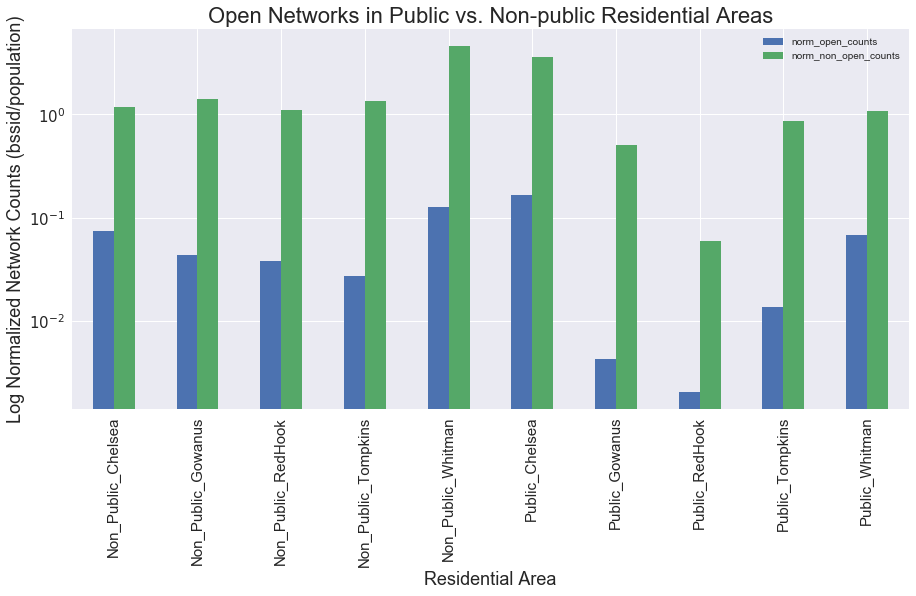

In [132]:
ax = bar_plot.plot(kind='bar', title ="Wifi Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 7), legend=True, fontsize=15)
ax.set_title("Open Networks in Public vs. Non-public Residential Areas",fontsize=22)
ax.set_xlabel("Residential Area", fontsize=18)
ax.set_ylabel("Log Normalized Network Counts (bssid/population)", fontsize=18)
ax.set_yscale("log")

In [133]:
bar_plot

,name,norm_open_counts,norm_non_open_counts
Non_Public_Chelsea,Non_Public_Chelsea,0.074869,1.185723
Non_Public_Gowanus,Non_Public_Gowanus,0.043656,1.409277
Non_Public_RedHook,Non_Public_RedHook,0.038108,1.101183
Non_Public_Tompkins,Non_Public_Tompkins,0.027498,1.361137
Non_Public_Whitman,Non_Public_Whitman,0.128205,4.571795
Public_Chelsea,Public_Chelsea,0.167529,3.567270
Public_Gowanus,Public_Gowanus,0.004346,0.501087
Public_RedHook,Public_RedHook,0.002061,0.059494
Public_Tompkins,Public_Tompkins,0.013630,0.858136
Public_Whitman,Public_Whitman,0.068071,1.085900


In [134]:
#contingency_table_Chelsea = bar_plot[bar_blot.index.str.contains("Chelsea","Chelsea_None")][["norm_open_counts","norm_non_open_counts"]]

In [135]:
#contingency_table_Chelsea

In [136]:
#from scipy.stats import chisquare

In [137]:
#obs = np.array([[0.104140,3.033635],[0.232414,2.323579]])

In [138]:
#obs

In [139]:
#chisquare(obs)

In [140]:
#obs

In [141]:
#chisquare(obs)

In [142]:
area_MHI = housing_gdf.groupby(["name"])["MHI"].unique()

In [143]:
housing_gdf.groupby(["name", "GEOID"])["MHI"].unique()

name                 GEOID       
Non_Public_Chelsea   360610091002    [43071]
                     360610091003    [70741]
Non_Public_Gowanus   360470043004    [47125]
                     360470069003    [49444]
                     360470069004    [51793]
Non_Public_RedHook   360470065001    [68750]
                     360470065002    [63889]
                     360470065003    [66181]
                     360470065004    [71875]
                     360470065005    [47260]
Non_Public_Tompkins  360470261001    [14426]
                     360470261002    [18814]
                     360470261003    [18167]
                     360470261004    [17083]
                     360470261005     [8561]
Non_Public_Whitman   360470033001    [52500]
                     360470181001    [61771]
                     360470181002    [71779]
                     360470181003    [34489]
Public_Chelsea       360610083003    [13210]
                     360610089003    [39788]
                     

In [144]:
area_MHI

name
Non_Public_Chelsea                               [43071, 70741]
Non_Public_Gowanus                        [47125, 51793, 49444]
Non_Public_RedHook          [63889, 66181, 68750, 71875, 47260]
Non_Public_Tompkins          [14426, 8561, 18814, 17083, 18167]
Non_Public_Whitman                 [52500, 34489, 71779, 61771]
Public_Chelsea                            [13210, 39788, 13889]
Public_Gowanus                                   [13202, 15868]
Public_RedHook                                          [10372]
Public_Tompkins        [13218, 13043, 11859, 9563, 13229, 9934]
Public_Whitman                                   [14091, 11185]
Name: MHI, dtype: object

In [145]:
area_MHI = pd.DataFrame(area_MHI)

In [146]:
area_MHI

,MHI
name,
Non_Public_Chelsea,"[43071, 70741]"
Non_Public_Gowanus,"[47125, 51793, 49444]"
Non_Public_RedHook,"[63889, 66181, 68750, 71875, 47260]"
Non_Public_Tompkins,"[14426, 8561, 18814, 17083, 18167]"
Non_Public_Whitman,"[52500, 34489, 71779, 61771]"
Public_Chelsea,"[13210, 39788, 13889]"
Public_Gowanus,"[13202, 15868]"
Public_RedHook,[10372]
Public_Tompkins,"[13218, 13043, 11859, 9563, 13229, 9934]"


In [147]:
area_MHI["area_MHI"] = list(map(lambda x: x[:].sum(), list(area_MHI.MHI)))

In [148]:
area_MHI.area_MHI[2].sum()

317955

In [149]:
area_MHI["name"] = area_MHI.index

In [150]:
scatter_plot = bar_plot.merge(area_MHI, on="name")

In [151]:
scatter_plot.index = scatter_plot.name

In [152]:
scatter_plot

,name,norm_open_counts,norm_non_open_counts,MHI,area_MHI
name,,,,,
Non_Public_Chelsea,Non_Public_Chelsea,0.074869,1.185723,"[43071, 70741]",113812
Non_Public_Gowanus,Non_Public_Gowanus,0.043656,1.409277,"[47125, 51793, 49444]",148362
Non_Public_RedHook,Non_Public_RedHook,0.038108,1.101183,"[63889, 66181, 68750, 71875, 47260]",317955
Non_Public_Tompkins,Non_Public_Tompkins,0.027498,1.361137,"[14426, 8561, 18814, 17083, 18167]",77051
Non_Public_Whitman,Non_Public_Whitman,0.128205,4.571795,"[52500, 34489, 71779, 61771]",220539
Public_Chelsea,Public_Chelsea,0.167529,3.567270,"[13210, 39788, 13889]",66887
Public_Gowanus,Public_Gowanus,0.004346,0.501087,"[13202, 15868]",29070
Public_RedHook,Public_RedHook,0.002061,0.059494,[10372],10372
Public_Tompkins,Public_Tompkins,0.013630,0.858136,"[13218, 13043, 11859, 9563, 13229, 9934]",70846


In [153]:
scatter_plot["mih_v_norm_open_counts"] = zip(scatter_plot.norm_open_counts,scatter_plot.MHI)
scatter_plot["mih_v_norm_non_open_counts"] = zip(scatter_plot.norm_non_open_counts,scatter_plot.MHI)

In [154]:
#housing_gdf_.groupby(["GEOID","open_net"])[]

In [155]:
housing_gdf_.groupby(housing_gdf_.GEOID)["open_net"].sum()

GEOID
360470029011     102.0
360470029012     168.0
360470033001     373.0
360470043004      76.0
360470065001      16.0
360470065002       4.0
360470065003       8.0
360470065004      10.0
360470065005      20.0
360470069003     558.0
360470069004     164.0
360470071003     121.0
360470085001      60.0
360470127003     399.0
360470181001     529.0
360470181002     382.0
360470181003     356.0
360470259021      40.0
360470261001       6.0
360470261002      24.0
360470261003      18.0
360470261004      30.0
360470261005      12.0
360470281001      35.0
360470283001      23.0
360470285021      31.0
360470287003      19.0
360470289004      13.0
360610083003    5035.0
360610089003    1638.0
360610091002    2278.0
360610091003    1184.0
360610097002    4956.0
Name: open_net, dtype: float64

In [156]:
open_counts = pd.DataFrame(housing_gdf_.groupby(["GEOID"])["open_net"].sum())

In [157]:
housing_gdf_.groupby(["GEOID","bssid"])["open_net"].sum()

GEOID         bssid            
360470029011  00:06:66:23:72:ee      0.0
              00:0c:42:3a:bb:44      0.0
              00:19:9d:ff:74:7f      0.0
              00:22:6b:7d:be:1a      0.0
              00:24:01:6c:5e:e9      0.0
              00:ac:e0:96:d7:45      0.0
              00:ac:e0:9f:4a:20      0.0
              00:ac:e0:9f:4a:25      0.0
              00:ac:e0:a4:f9:60      0.0
              00:ac:e0:a4:f9:65      0.0
              04:a1:51:da:17:59      0.0
              04:a1:51:da:17:5a      0.0
              08:02:8e:ce:5f:a5      0.0
              08:3e:0c:d8:30:b5      0.0
              08:3e:0c:d9:28:70      0.0
              08:3e:0c:d9:28:75      0.0
              08:3e:0c:da:7f:f0      0.0
              08:3e:0c:da:7f:f5      0.0
              08:3e:0c:db:18:e0      0.0
              08:3e:0c:db:18:e5      0.0
              08:3e:8e:90:07:4f      0.0
              08:86:3b:30:2e:60      0.0
              08:86:3b:78:c5:e8      0.0
              08:95:2a:cd

In [158]:
open_counts_by_bssid = pd.DataFrame(housing_gdf_.groupby(["GEOID","bssid"])["open_net"].sum())

In [159]:
open_counts_by_bssid

open_net
GEOID        bssid                      
360470029011 00:06:66:23:72:ee       0.0
             00:0c:42:3a:bb:44       0.0
             00:19:9d:ff:74:7f       0.0
             00:22:6b:7d:be:1a       0.0
             00:24:01:6c:5e:e9       0.0
             00:ac:e0:96:d7:45       0.0
             00:ac:e0:9f:4a:20       0.0
             00:ac:e0:9f:4a:25       0.0
             00:ac:e0:a4:f9:60       0.0
             00:ac:e0:a4:f9:65       0.0
             04:a1:51:da:17:59       0.0
             04:a1:51:da:17:5a       0.0
             08:02:8e:ce:5f:a5       0.0
             08:3e:0c:d8:30:b5       0.0
             08:3e:0c:d9:28:70       0.0
             08:3e:0c:d9:28:75       0.0
             08:3e:0c:da:7f:f0       0.0
             08:3e:0c:da:7f:f5       0.0
             08:3e:0c:db:18:e0       0.0
             08:3e:0c:db:18:e5       0.0
             08:3e:8e:90:07:4f       0.0
             08:86:3b:30:2e:60       0.0
             08:86:3b:78:c5:e8       0.0
             08:95:2a:cd:cb:94       0.0
             08:95:2a:ec:94:a5       0.0
             0a:47:c9:35:6e:58       0.0
             0c:f8:93:bc:27:a0       0.0
             10:0d:7f:d1:9b:70       0.0
             10:0d:7f:d1:bf:3f       0.0
             10:78:5b:17:3d:b1       0.0
...                                  ...
360610097002 f8:e7:1e:55:dd:08       0.0
             f8:e7:1e:55:dd:0c       0.0
             f8:e7:1e:6c:81:a8       0.0
             f8:e7:1e:6c:81:ac       0.0
             f8:e7:1e:95:dd:08       0.0
             f8:e7:1e:95:dd:0c       0.0
             f8:e7:1e:ac:81:a8     391.0
             f8:e7:1e:ac:81:ac     382.0
             f8:e7:1e:ec:81:a8       0.0
             f8:e7:1e:ec:81:ac       0.0
             fa:8f:ca:3b:fc:b1       0.0
             fa:8f:ca:50:4b:41       0.0
             fa:8f:ca:52:1f:d8       0.0
             fa:8f:ca:8d:cb:ae       0.0
             fa:8f:ca:8e:0e:fc       0.0
             fc:15:b4:6f:92:0b       0.0
             fc:52:8d:0b:13:74       0.0
             fc:52:8d:0b:13:75       0.0
             fc:52:8d:0c:b1:08       0.0
             fc:52:8d:42:e3:63       0.0
             fc:52:8d:42:e3:64       0.0
             fc:52:8d:43:52:8d       0.0
             fc:52:8d:43:52:8e       0.0
             fc:52:8d:4f:6c:6d       0.0
             fc:52:8d:4f:6c:6e       0.0
             fc:52:8d:58:ec:6b       0.0
             fc:52:8d:ff:6c:39       0.0
             fc:52:8d:ff:6c:3a       0.0
             fe:1e:df:fc:cd:f3      34.0
             fe:a6:67:db:16:0a       0.0

[24357 rows x 1 columns]

In [160]:
open_counts_by_bssid["open_net_counts"] = list(map(lambda x: x > 0, open_counts_by_bssid.open_net))
open_counts_by_bssid["non_open_net_counts"] = list(map(lambda x: x == 0, open_counts_by_bssid.open_net))

In [161]:
open_counts_by_bssid["GEOID"] = list(map(lambda x: list(x),open_counts_by_bssid.index))
open_counts_by_bssid["GEOID"] = list(map(lambda x: x[0][:], open_counts_by_bssid["GEOID"]))

In [162]:
open_counts_by_bssid_ = pd.DataFrame(open_counts_by_bssid.groupby(open_counts_by_bssid.GEOID)[["open_net_counts","non_open_net_counts"]].sum())

In [163]:
open_counts_by_bssid_.head()

,open_net_counts,non_open_net_counts
GEOID,,
360470029011,23.0,367.0
360470029012,28.0,383.0
360470033001,31.0,1525.0
360470043004,9.0,116.0
360470065001,9.0,247.0


In [164]:
open_counts_by_bssid_["GEOID"] = open_counts_by_bssid_.index

In [165]:
housing_bg_final = housing_gdf_.merge(open_counts_by_bssid_, on="GEOID", how="inner")

In [166]:
housing_bg_final.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Professional_School_Degree,Doctorate,index_right,cartodb_id,descriptio,name,uni_bssid_by_housing_area,open_net,open_net_counts,non_open_net_counts
0,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,0,0,8,,Public_RedHook,448,False,15.0,433.0
1,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,0,0,8,,Public_RedHook,448,False,15.0,433.0
2,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,0,0,8,,Public_RedHook,448,False,15.0,433.0
3,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,0,0,8,,Public_RedHook,448,False,15.0,433.0
4,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,0,0,8,,Public_RedHook,448,True,15.0,433.0


In [167]:
housing_bg_final.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'acc', 'bssid', 'lat', 'level', 'lng', 'ssid', 'time',
       'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x', 'Geo_AREALAND_x',
       'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x', 'Geo_REGION_x',
       'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x', 'Geo_TRACT_x',
       'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y', 'Geo_AREALAND_y',
       'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y', 'Geo_REGION_y',
       'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y', 'Geo_TRACT_y',
       'Geo_BLKGRP_y', 'SE_T003_003', 'Population', 'Pop_Density', 'Geo_NAME',
       'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS', 'High_School',
       'Some_College', 'Bachelors', '

In [168]:
housing_bg_final["norm_open_counts"] = list(map(lambda x,y: x/y,\
                                                              housing_bg_final.open_net_counts,\
                                                              housing_bg_final.Population))
housing_bg_final["norm_non_open_counts"] = list(map(lambda x,y: x/y, housing_bg_final.non_open_net_counts,\
                                                                 housing_bg_final.Population))

In [169]:
bar_plot_bg = housing_bg_final[["GEOID","norm_open_counts","norm_non_open_counts"]]

In [170]:
bar_plot_bg = bar_plot_bg.drop_duplicates(subset="GEOID", keep='first', inplace=False)

In [171]:
bar_plot_bg.index = bar_plot_bg.GEOID

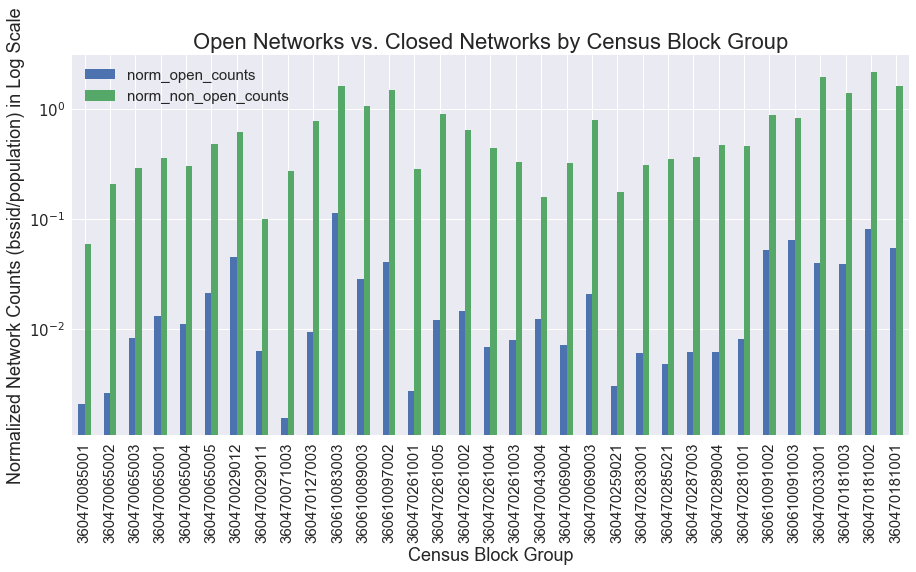

In [178]:
ax = bar_plot_bg.plot(kind='bar', figsize=(15, 7), legend=True, fontsize=15)
ax.set_title("Open Networks vs. Closed Networks by Census Block Group",fontsize=22)
ax.set_xlabel("Census Block Group", fontsize=18)
ax.set_ylabel("Normalized Network Counts (bssid/population) in Log Scale", fontsize=18)
ax.set_yscale("log")
plt.legend(loc='upper left', fontsize=15)

In [194]:
# MOVE THIS DOWN

In [195]:
scatter_plot

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,public
1416,Non_Public_RedHook,360470065002,63889,0.002628,0.206307,False,non-public
1651,Non_Public_RedHook,360470065003,66181,0.008230,0.286694,False,non-public
1986,Non_Public_RedHook,360470065001,68750,0.013006,0.356936,False,non-public
2447,Non_Public_RedHook,360470065004,71875,0.011200,0.304000,False,non-public
2844,Non_Public_RedHook,360470065005,47260,0.021053,0.482456,False,non-public
3431,Public_Whitman,360470029012,14091,0.045381,0.620746,True,public
4870,Public_Whitman,360470029011,11185,0.006245,0.099647,True,public
6320,Public_Gowanus,360470071003,13202,0.001552,0.274759,True,public
22628,Public_Gowanus,360470127003,15868,0.009404,0.769070,True,public


In [196]:
scatter_plot["target_area_label"] = (["3"]*6) + (["5"]*2) + (["2"]*2) + (["1"]*3) + \
                              (["4"]*5) + (["2"]*3) + (["4"]*6) + (["1"]*2) + (["5"]*4)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [197]:
scatter_plot["target_area"] = (["Redhook"]*6) + (["Whiteman"]*2) + (["Gowanus"]*2) + (["Chelsea"]*3) + \
                              (["Tompkins"]*5) + (["Gowanus"]*3) + (["Tompkins"]*6) + (["Chelsea"]*2) + (["Whiteman"]*4)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [198]:
scatter_plot.pivot_table(values=["norm_open_counts","norm_non_open_counts"],index="target_area",columns="Public_cat")

norm_open_counts           norm_non_open_counts          
Public_cat        non-public    public           non-public    public
target_area                                                          
Chelsea             0.057660  0.060905             0.850020  1.381346
Gowanus             0.013320  0.005478             0.423475  0.521915
Redhook             0.011223  0.002061             0.327279  0.059494
Tompkins            0.008840  0.005728             0.519872  0.353928
Whiteman            0.053302  0.025813             1.778468  0.360196

In [335]:
scatter_plot.rename(columns={'norm_open_counts': 'Open Wifi', 'norm_non_open_counts': 'Closed Wifi'}, inplace=True)

/Applications/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [244]:
bar_plot_area = scatter_plot.pivot_table(values=["Open Wifi","Closed Wifi"],index="target_area",columns="Public_cat")

In [245]:
bar_plot_area.head()

Open Wifi              Closed Wifi            
Public_cat  Private Area Public Area Private Area Public Area
target_area                                                  
Chelsea         0.057660    0.060905     0.850020    1.381346
Gowanus         0.013320    0.005478     0.423475    0.521915
Redhook         0.011223    0.002061     0.327279    0.059494
Tompkins        0.008840    0.005728     0.519872    0.353928
Whiteman        0.053302    0.025813     1.778468    0.360196

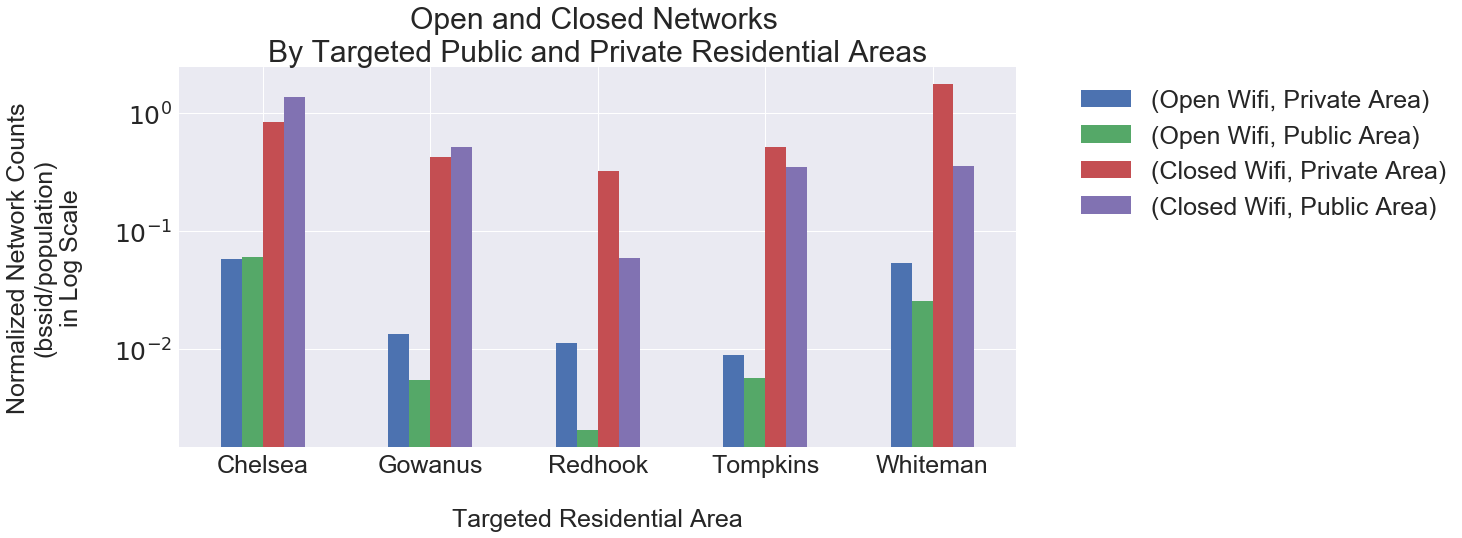

In [247]:
ax = bar_plot_area.plot(kind='bar', figsize=(15, 7), legend=True, fontsize=15)
ax.set_title("Open and Closed Networks \nBy Targeted Public and Private Residential Areas",fontsize=30)
ax.set_ylabel("Normalized Network Counts\n(bssid/population)\nin Log Scale\n", fontsize=25)
ax.set_xlabel("\nTargeted Residential Area", fontsize=25)
ax.set_yscale("log")
ax.tick_params(axis='both', labelsize=25)
plt.xticks(rotation = 0)
plt.legend(loc='upper left', fontsize=25, bbox_to_anchor=(1.05, 1))

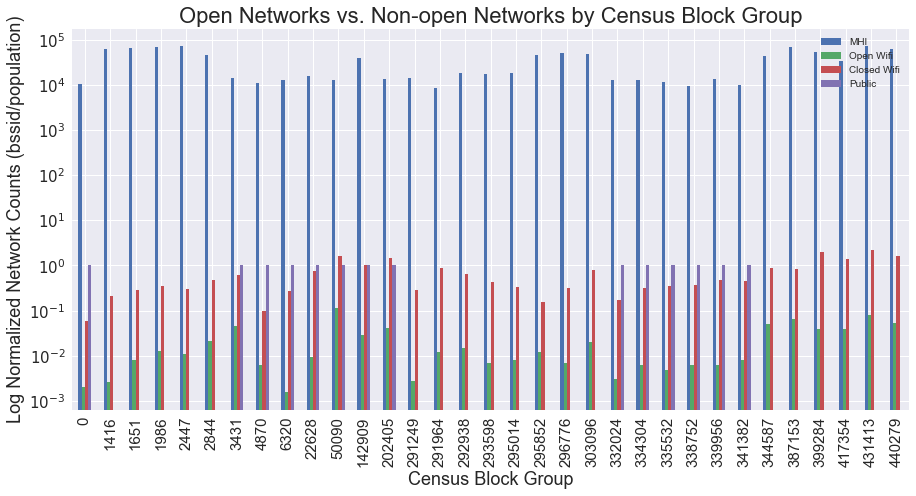

In [248]:
ax = scatter_plot.plot(kind='bar', figsize=(15, 7), legend=True, fontsize=15)
ax.set_title("Open Networks vs. Non-open Networks by Census Block Group",fontsize=22)
ax.set_xlabel("Census Block Group", fontsize=18)
ax.set_ylabel("Log Normalized Network Counts (bssid/population)", fontsize=18)
ax.set_yscale("log")

In [ ]:
# MOVE THIS UP

In [185]:
housing_bg_final.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'acc', 'bssid', 'lat', 'level', 'lng', 'ssid', 'time',
       'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x', 'Geo_AREALAND_x',
       'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x', 'Geo_REGION_x',
       'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x', 'Geo_TRACT_x',
       'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y', 'Geo_AREALAND_y',
       'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y', 'Geo_REGION_y',
       'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y', 'Geo_TRACT_y',
       'Geo_BLKGRP_y', 'SE_T003_003', 'Population', 'Pop_Density', 'Geo_NAME',
       'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS', 'High_School',
       'Some_College', 'Bachelors', '

In [186]:
housing_scatter_plot = housing_bg_final[["name","GEOID","geometry","uni_bssid_count","MHI","Population",\
                                     "Pop_Density","Geo_TRACT","Geo_BLKGRP","Pop_over_25",\
                                     "Less_than_HS","High_School","Some_College","Bachelors",\
                                     "Masters","Professional_School_Degree","Doctorate",\
                                     "norm_open_counts","norm_non_open_counts"]]

In [187]:
housing_scatter_plot = housing_scatter_plot.drop_duplicates(subset="GEOID", keep='first', inplace=False)

In [188]:
housing_scatter_plot.columns

Index(['name', 'GEOID', 'geometry', 'uni_bssid_count', 'MHI', 'Population',
       'Pop_Density', 'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS',
       'High_School', 'Some_College', 'Bachelors', 'Masters',
       'Professional_School_Degree', 'Doctorate', 'norm_open_counts',
       'norm_non_open_counts'],
      dtype='object')

In [189]:
housing_scatter_plot.shape

(33, 19)

In [190]:
scatter_plot = housing_scatter_plot[["name","GEOID","MHI","norm_open_counts","norm_non_open_counts"]]

In [191]:
def public(x):
    if "Non" in str(x):
        return False
    else:
        return True

In [243]:
scatter_plot["Public"] = list(map(lambda x: public(x), scatter_plot.name))
scatter_plot["Public_cat"] = list(map(lambda x: "Public Area" if x == True else "Private Area", scatter_plot.Public))

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [235]:
scatter_plot

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,target_area_label,target_area
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,Public,3,Redhook
1416,Non_Public_RedHook,360470065002,63889,0.002628,0.206307,False,Private,3,Redhook
1651,Non_Public_RedHook,360470065003,66181,0.008230,0.286694,False,Private,3,Redhook
1986,Non_Public_RedHook,360470065001,68750,0.013006,0.356936,False,Private,3,Redhook
2447,Non_Public_RedHook,360470065004,71875,0.011200,0.304000,False,Private,3,Redhook
2844,Non_Public_RedHook,360470065005,47260,0.021053,0.482456,False,Private,3,Redhook
3431,Public_Whitman,360470029012,14091,0.045381,0.620746,True,Public,5,Whiteman
4870,Public_Whitman,360470029011,11185,0.006245,0.099647,True,Public,5,Whiteman
6320,Public_Gowanus,360470071003,13202,0.001552,0.274759,True,Public,2,Gowanus
22628,Public_Gowanus,360470127003,15868,0.009404,0.769070,True,Public,2,Gowanus


In [ ]:
# MOVE THIS UP

# Factoring for Building Height

In [249]:
floors_data = pd.read_excel("../Downloads/data/avg_floor.xlsx", converters={"GEO_ID":str})

In [250]:
floors_data = floors_data.rename(columns={"GEO_ID":"GEOID", "avg of num floor":"mean_floors"})

In [251]:
housing_bg_final.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'acc', 'bssid', 'lat', 'level', 'lng', 'ssid', 'time',
       'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x', 'Geo_AREALAND_x',
       'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x', 'Geo_REGION_x',
       'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x', 'Geo_TRACT_x',
       'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y', 'Geo_AREALAND_y',
       'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y', 'Geo_REGION_y',
       'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y', 'Geo_TRACT_y',
       'Geo_BLKGRP_y', 'SE_T003_003', 'Population', 'Pop_Density', 'Geo_NAME',
       'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS', 'High_School',
       'Some_College', 'Bachelors', '

In [252]:
floors = housing_bg_final[["GEOID","name","MHI","Population","open_net_counts","non_open_net_counts"]]

In [253]:
floors = floors.drop_duplicates(["GEOID"])

In [254]:
floors["Public"] = list(map(lambda x: public(x), floors.name))
floors["Public_cat"] = list(map(lambda x: "Public Area" if x == True else "Private Area", floors.Public))

In [255]:
floors.head(1)

,GEOID,name,MHI,Population,open_net_counts,non_open_net_counts,Public,Public_cat
0,360470085001,Public_RedHook,10372,7278,15.0,433.0,True,Public Area


In [256]:
floors = floors.merge(floors_data, on="GEOID")

In [257]:
floors["Open Wifi"] = list(map(lambda x,y,z: (x*y)/z, floors.open_net_counts, floors.mean_floors, floors.Population))
floors["Closed Wifi"] = list(map(lambda x,y,z: (x*y)/z, floors.non_open_net_counts, floors.mean_floors, floors.Population))

In [259]:
floors["log_norm_open_counts"] = list(map(lambda x: log(x), floors["Open Wifi"]))
floors["log_norm_non_open_counts"] = list(map(lambda x: log(x), floors["Closed Wifi"]))
floors["log_MHI"] = list(map(lambda x: log(x), floors.MHI))

In [260]:
floors.head(1)

,GEOID,name,MHI,Population,open_net_counts,non_open_net_counts,Public,Public_cat,mean_floors,Open Wifi,Closed Wifi,log_norm_open_counts,log_norm_non_open_counts,log_MHI
0,360470085001,Public_RedHook,10372,7278,15.0,433.0,True,Public Area,2.0,0.004122,0.118989,-5.491414,-2.128726,9.246865


In [478]:
# Open Networks
X1_floors = floors["Open Wifi"]
y = floors.MHI
r1_floors = scipy.stats.pearsonr(X1_floors, y)
print(r1_floors)
print(y.describe())

X1_floors = sm.add_constant(X1_floors)
model1_floors = sm.OLS(y, X1_floors).fit()

predictions1_floors = model1_floors.predict(X1_floors)
print(predictions1_floors)

#model1_floors.summary()

(0.3506495470459311, 0.045425675636149389)
count       33.000000
mean     32732.424242
std      23229.770313
min       8561.000000
25%      13210.000000
50%      18167.000000
75%      51793.000000
max      71875.000000
Name: MHI, dtype: float64
[ 27265.30368024  27483.79171343  28366.43952508  29218.75004045
  28896.45057039  30654.968954    39046.9619606   28430.03220809
  27313.04115416  28575.96609579  52295.93887869  31965.90826669
  35927.79543111  27388.23591904  29036.79129082  29517.90602905
  28115.165179    28317.73301033  27993.1801727   28476.00735723
  30575.26402856  27716.63175375  28257.00391127  27752.89418053
  27444.52261394  27998.22170665  28347.61811012  40726.44725054
  55305.68883459  33990.97043507  40707.3205121   55628.71606334
  41432.33316268]


In [479]:
# Non-open Networks
X2_floors = floors["Closed Wifi"]
y = floors.MHI
r2_floors = scipy.stats.pearsonr(X2_floors, y)
print(r2_floors)
print(y.describe())

X2_floors = sm.add_constant(X2_floors)
model2_floors = sm.OLS(y, X2_floors).fit()

predictions2_floors = model2_floors.predict(X2_floors)
print(predictions2_floors)

#model2_floors.summary()

(0.34451896571808327, 0.049602505910965086)
count       33.000000
mean     32732.424242
std      23229.770313
min       8561.000000
25%      13210.000000
50%      18167.000000
75%      51793.000000
max      71875.000000
Name: MHI, dtype: float64
[ 25683.44557217  27345.16888791  27586.48052495  28174.833236
  27731.43549036  29226.19195537  32984.20601967  26332.75896904
  28637.21323191  31626.88231238  42197.26422111  33974.58408652
  40574.43689067  27565.11228693  32729.29466846  30582.40581126
  28858.82160907  27962.32102926  25847.88833159  28580.47792099
  31784.42545775  27393.8774265   28432.68543956  28121.46492771
  26696.65710199  29125.91765292  29001.45314602  36159.53433541
  42493.46351749  41561.35781364  48418.08398058  61263.39502291
  45516.46112193]


In [480]:
floors.head(1)

,GEOID,name,MHI,Population,open_net_counts,non_open_net_counts,Public,Public_cat,mean_floors,Open Wifi,Closed Wifi,log_norm_open_counts,log_norm_non_open_counts,log_MHI
0,360470085001,Public_RedHook,10372,7278,15.0,433.0,True,Public Area,2.0,0.004122,0.118989,-5.491414,-2.128726,9.246865


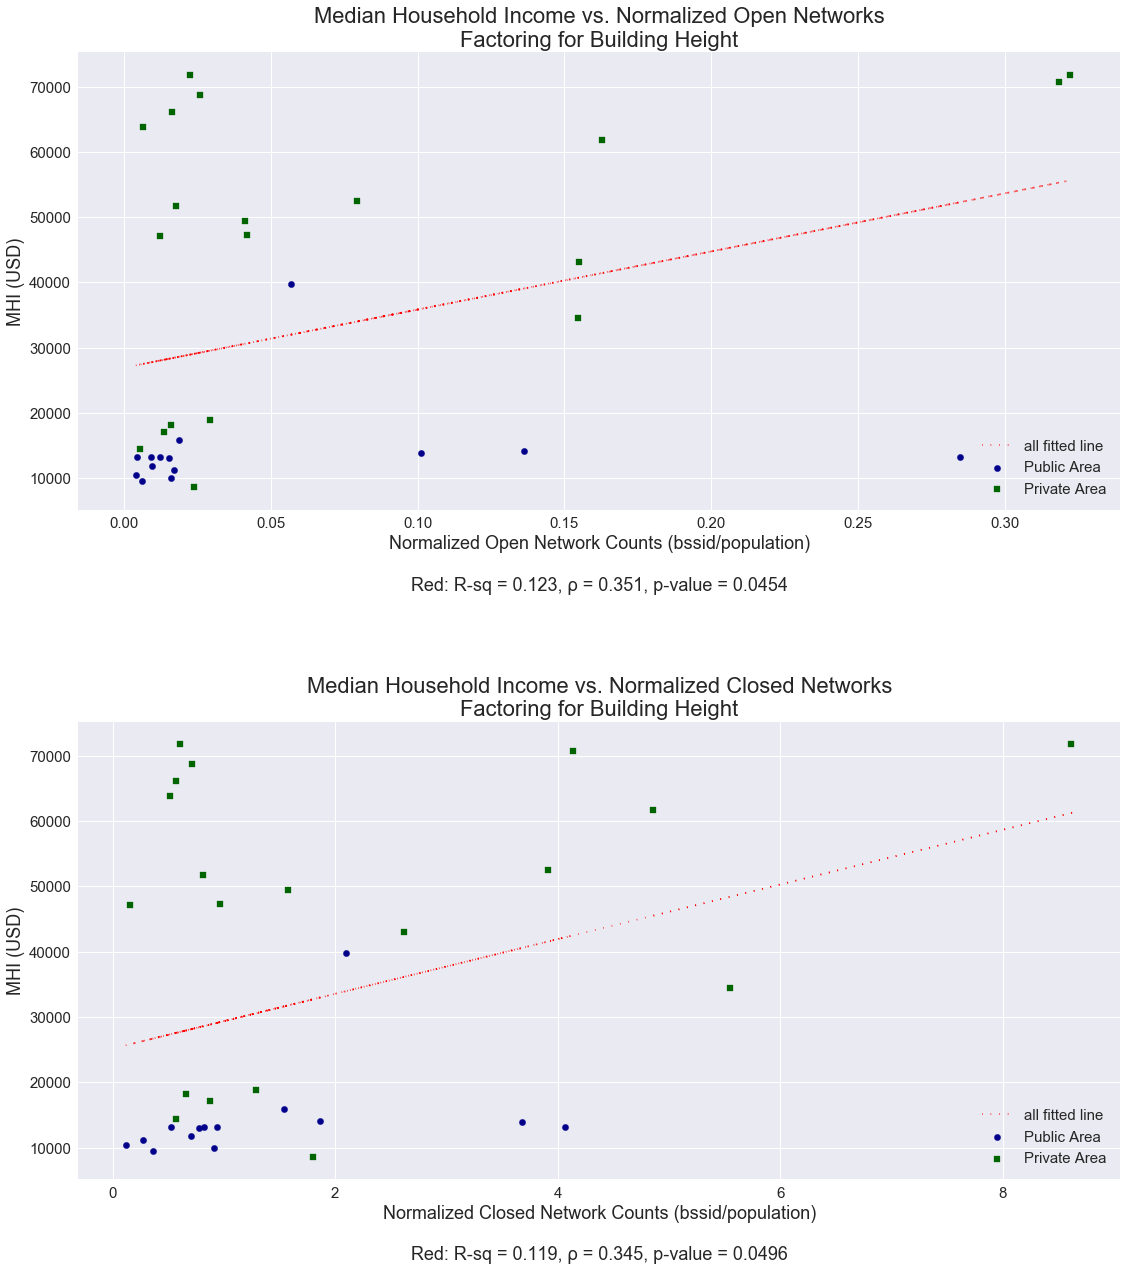

In [481]:
# Factoring for Floors
ax1 = plt.subplot(2,1,1)

floors[floors.Public_cat == "Public Area"].plot(kind='scatter', title ="Open Networks in Public vs. Private Residential Areas", \
                   figsize=(16, 18), legend=True, fontsize=15, x='Open Wifi', \
                  y='MHI', s=40, color='DarkBlue',\
                      label='Public Area', ax=ax1, marker="o")
floors[floors.Public_cat == "Private Area"].plot(kind='scatter', title ="Open Networks in Public vs. Private Residential Areas", \
                   figsize=(16, 18), legend=True, fontsize=15, x='Open Wifi', \
                  y='MHI', s=40, color='DarkGreen',\
                      label='Private Area', ax=ax1, marker="s")
plt.plot(X1_floors["Open Wifi"], predictions1_floors, color="red", linestyle='--', dashes=(.3, 4), label="all fitted line")
#plt.plot(X_open_public.log_norm_open_counts, predictions1_open_public, color="orange", linestyle='--', dashes=(.3, 4), label="public fitted line")
#plt.plot(X_non_open_public.log_norm_open_counts, predictions1_non_open_public, color="purple", linestyle='--', dashes=(.3, 4), label="non-public fitted line")

ax1.set_title("Median Household Income vs. Normalized Open Networks\nFactoring for Building Height",fontsize=22)
ax1.set_xlabel("                Normalized Open Network Counts (bssid/population)\
                \n\nRed: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}\n\n\n".format(model1_floors.rsquared,r1_floors[0],r1_floors[1]),fontsize=18)
                
ax1.set_ylabel("MHI (USD)", fontsize=18)
#ax1.set_yscale("log")
#ax1.set_xscale("log")

plt.legend(fontsize=15)
plt.tight_layout()

ax2 = plt.subplot(2,1,2)

floors[floors.Public_cat == "Public Area"].plot(kind='scatter', title ="Closed Networks in Public vs. Private Residential Areas", \
                   figsize=(16, 18), legend=True, fontsize=15, x='Closed Wifi', y='MHI', s=40,\
                       color='DarkBlue', label='Public Area', ax=ax2, marker="o")
floors[floors.Public_cat == "Private Area"].plot(kind='scatter', title ="Closed Networks in Public vs. Private Residential Areas", \
                   figsize=(16, 18), legend=True, fontsize=15, x='Closed Wifi', y='MHI', s=40,\
                       color='DarkGreen', label='Private Area', ax=ax2, marker="s")
plt.plot(X2_floors["Closed Wifi"], predictions2_floors, color="red", linestyle='--', dashes=(.3, 4), label="all fitted line")
#plt.plot(X2_non_open_public.log_norm_non_open_counts, predictions2_non_open_public, color="orange", linestyle='--', dashes=(.3, 4), label="public fitted line")
#plt.plot(X2_non_open_non_public.log_norm_non_open_counts, predictions2_non_open_non_public, color="purple", linestyle='--', dashes=(.3, 4), label="non-public fitted line")

ax2.set_title("Median Household Income vs. Normalized Closed Networks\nFactoring for Building Height",fontsize=22)
ax2.set_xlabel("                Normalized Closed Network Counts (bssid/population)\
                \n\nRed: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}".format(model2_floors.rsquared,r2_floors[0],r2_floors[1]),fontsize=18)
                
ax2.set_ylabel("MHI (USD)", fontsize=18)
#ax2.set_yscale("log")
#ax2.set_xscale("log")
plt.legend(fontsize=15)
plt.tight_layout()

In [482]:
floors.head(1)

,GEOID,name,MHI,Population,open_net_counts,non_open_net_counts,Public,Public_cat,mean_floors,Open Wifi,Closed Wifi,log_norm_open_counts,log_norm_non_open_counts,log_MHI
0,360470085001,Public_RedHook,10372,7278,15.0,433.0,True,Public Area,2.0,0.004122,0.118989,-5.491414,-2.128726,9.246865


In [483]:
# Non-open Networks logged - factoring for building height
X2_floors = floors["log_norm_non_open_counts"]
y = floors.log_MHI
r2_floors = scipy.stats.pearsonr(X2_floors, y)
print(r2_floors)
print(y.describe())

X2_floors = sm.add_constant(X2_floors)
model2_floors = sm.OLS(y, X2_floors).fit()

predictions2_floors = model2_floors.predict(X2_floors)
print(predictions2_floors)

#model2_floors.summary()

(0.28898556254991797, 0.10286917210645641)
count    33.000000
mean     10.126517
std       0.758471
min       9.054972
25%       9.488729
50%       9.807362
75%      10.855010
max      11.182684
Name: log_MHI, dtype: float64
[  9.64143603   9.95892496   9.98185067  10.02928944   9.99453869
  10.09452042  10.23685207   9.822021    10.06041927  10.19546107
  10.40568557  10.26273107  10.3839831    9.97991577  10.22965842
  10.15716534  10.07388813  10.0133279    9.70316846  10.05683194
  10.2006916    9.9637522   10.04719802  10.02539032   9.88164258
  10.08908109  10.08213373  10.31079133  10.4094222   10.39743872
  10.47314891  10.5684237   10.44426927]


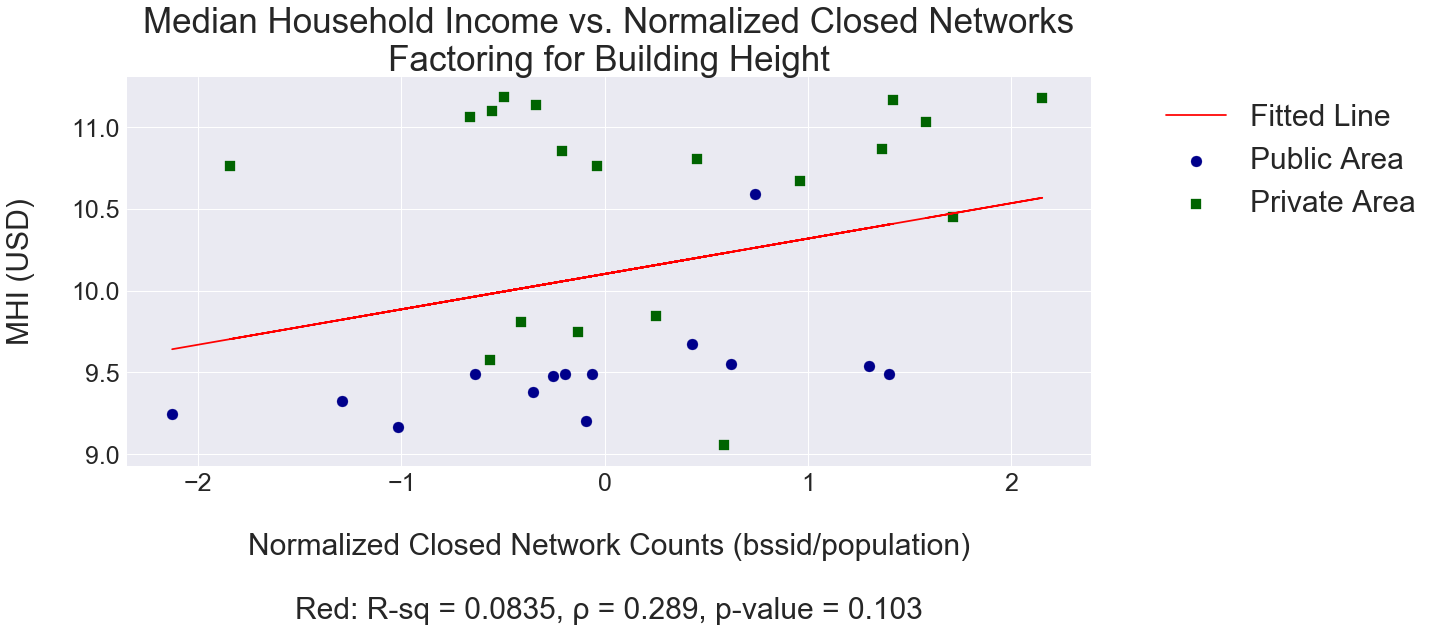

In [484]:
ax2 = plt.subplot(1,1,1)

floors[floors.Public_cat == "Public Area"].plot(kind='scatter', title ="Closed Networks in Public vs. Private Residential Areas", \
                   figsize=(16, 9), legend=True, fontsize=15, x='log_norm_non_open_counts', y='log_MHI', s=120,\
                       color='DarkBlue', label='Public Area', ax=ax2, marker="o")
floors[floors.Public_cat == "Private Area"].plot(kind='scatter', title ="Closed Networks in Public vs. Private Residential Areas", \
                   figsize=(16, 9), legend=True, fontsize=15, x='log_norm_non_open_counts', y='log_MHI', s=120,\
                       color='DarkGreen', label='Private Area', ax=ax2, marker="s")
plt.plot(X2_floors["log_norm_non_open_counts"], predictions2_floors, color="red", linestyle='-', label="Fitted Line")
#plt.plot(X2_non_open_public.log_norm_non_open_counts, predictions2_non_open_public, color="orange", linestyle='--', dashes=(.3, 4), label="public fitted line")
#plt.plot(X2_non_open_non_public.log_norm_non_open_counts, predictions2_non_open_non_public, color="purple", linestyle='--', dashes=(.3, 4), label="non-public fitted line")

ax2.set_title("Median Household Income vs. Normalized Closed Networks\nFactoring for Building Height",fontsize=35)
ax2.set_xlabel("\n                Normalized Closed Network Counts (bssid/population)\
                \n\nRed: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}".format(model2_floors.rsquared,r2_floors[0],r2_floors[1]),fontsize=30)
                
ax2.set_ylabel("MHI (USD)\n", fontsize=30)
#ax2.set_yscale("log")
#ax2.set_xscale("log")
#plt.legend(fontsize=15)
plt.tight_layout()
#ax2.set_yscale("log")
ax2.tick_params(axis='both', labelsize=25)
plt.xticks(rotation = 0)
plt.legend(loc='upper left', fontsize=30, bbox_to_anchor=(1.05, 1))

# Boxplots

In [298]:
scatter_plot.head(1)

,name,GEOID,MHI,Open Wifi,Closed Wifi,Public,Public_cat,target_area_label,target_area
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,Public Area,3,Redhook


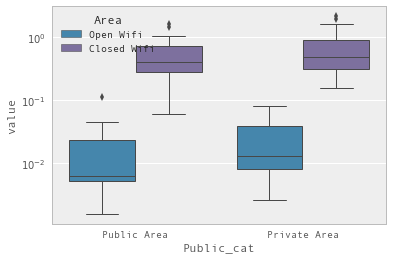

In [330]:
ax = plt.subplot()
dd = pd.melt(scatter_plot,id_vars=['Public_cat'],value_vars=["Open Wifi","Closed Wifi"],var_name='Area')
sns.boxplot(x='Public_cat',y='value',data=dd,hue='Area', ax=ax)
ax.set_yscale("log")

In [413]:
scatter_plot_box = scatter_plot.rename(columns={'Open Wifi': 'norm_open_counts', 'Closed Wifi': 'norm_non_open_counts'})

In [414]:
scatter_plot_box["log_norm_open_counts"] = list(map(lambda x: log(x), scatter_plot_box.norm_open_counts))
scatter_plot_box["log_norm_non_open_counts"] = list(map(lambda x: log(x), scatter_plot_box.norm_non_open_counts))
scatter_plot_box.head(1)

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,target_area_label,target_area,log_norm_open_counts,log_norm_non_open_counts
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,Public Area,3,Redhook,-6.184561,-2.821874


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Applications/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

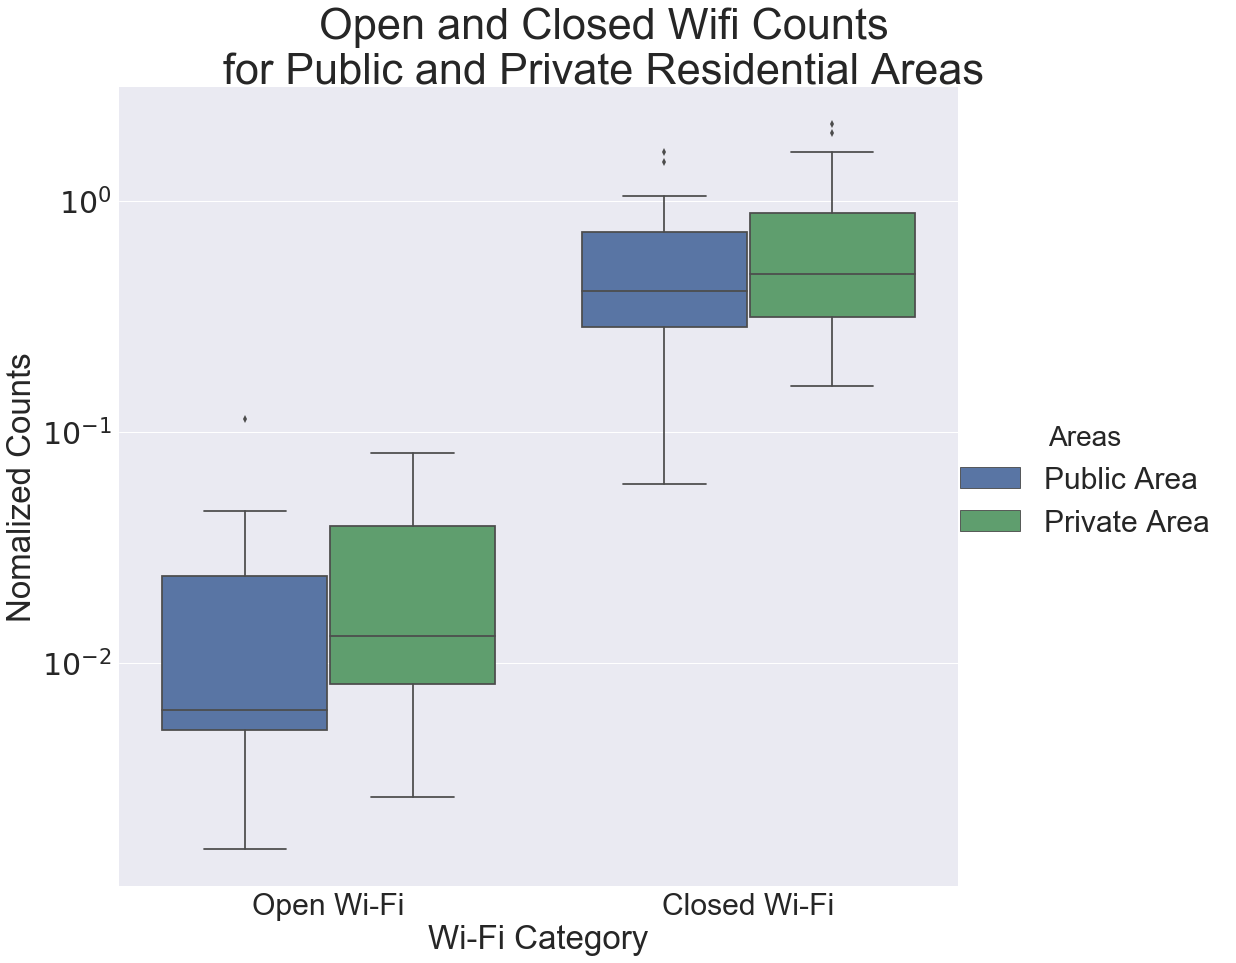

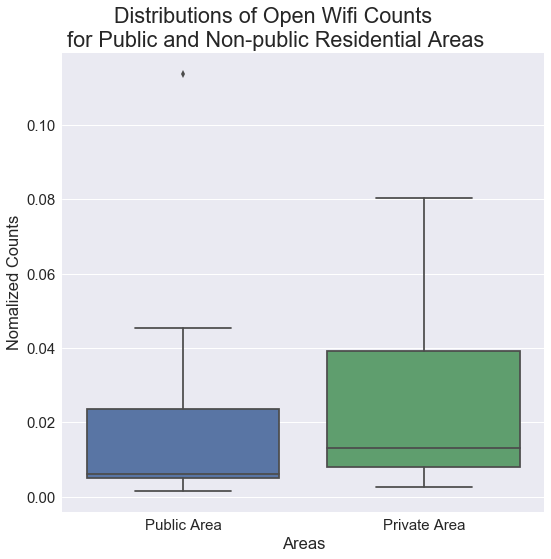

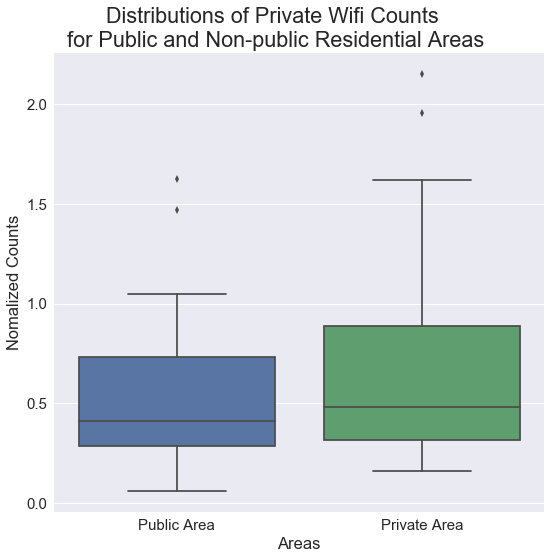

In [415]:
df = scatter_plot_box
df_new = df[['Public_cat', 'log_norm_open_counts', 'norm_open_counts']]
df_new['Wi-Fi Category'] = 'Open Wi-Fi'
df_new.rename(columns={'Public_cat':'Areas','log_norm_open_counts':'Nomalized Counts in Log Scale', 'norm_open_counts': 'Nomalized Counts'},inplace=True)
df_nnw = df[['Public_cat', 'log_norm_non_open_counts', 'norm_non_open_counts']]
df_nnw['Wi-Fi Category'] = 'Closed Wi-Fi'
df_nnw.rename(columns={'Public_cat':'Areas', 'log_norm_non_open_counts':'Nomalized Counts in Log Scale','norm_non_open_counts':'Nomalized Counts'},inplace=True)
ddf = pd.concat([df_new, df_nnw], axis =0)
ddf.head()
sns.set(font_scale=3)
ax = sns.factorplot(x="Wi-Fi Category", y="Nomalized Counts", hue="Areas", data=ddf, size = 14, kind="box")
ax.fig.get_axes()[0].set_yscale('log')
#ax.set_yscale("log")
plt.subplots_adjust(top=0.9)
#plt.legend(fontsize=12)
ax.fig.suptitle('Open and Closed Wifi Counts\nfor Public and Private Residential Areas\n')
sns.set(font_scale=1.5)
ax = sns.factorplot(x="Areas", y="Nomalized Counts", data=df_new, size = 8, kind="box")
plt.subplots_adjust(top=0.9)
#plt.legend(fontsize=12)
ax.fig.suptitle('Distributions of Open Wifi Counts \nfor Public and Non-public Residential Areas')
sns.set(font_scale=1.5)
ax = sns.factorplot(x="Areas", y="Nomalized Counts", data=df_nnw, size = 8, kind="box")
plt.subplots_adjust(top=0.9)
#plt.legend(fontsize=12)
ax.fig.suptitle('Distributions of Private Wifi Counts \nfor Public and Non-public Residential Areas')

# Scatter Plots

In [418]:
scatter_plot.rename(columns={'Open Wifi': 'norm_open_counts', 'Closed Wifi': 'norm_non_open_counts'}, inplace=True)

/Applications/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [419]:
scatter_plot.head(1)

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,target_area_label,target_area
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,Public Area,3,Redhook


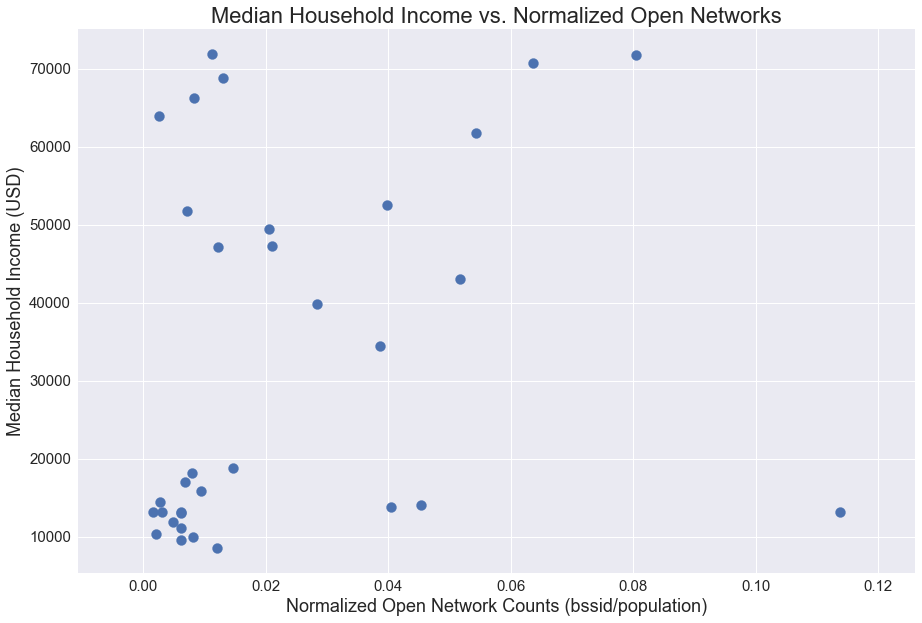

In [420]:
ax = scatter_plot.plot(kind='scatter', figsize=(15, 10), legend=True, fontsize=15,\
                       x='norm_open_counts', y='MHI', s=100)
ax.set_title("Median Household Income vs. Normalized Open Networks",fontsize=22)
ax.set_xlabel("Normalized Open Network Counts (bssid/population)", fontsize=18)
ax.set_ylabel("Median Household Income (USD)", fontsize=18)
#ax.set_yscale("log")

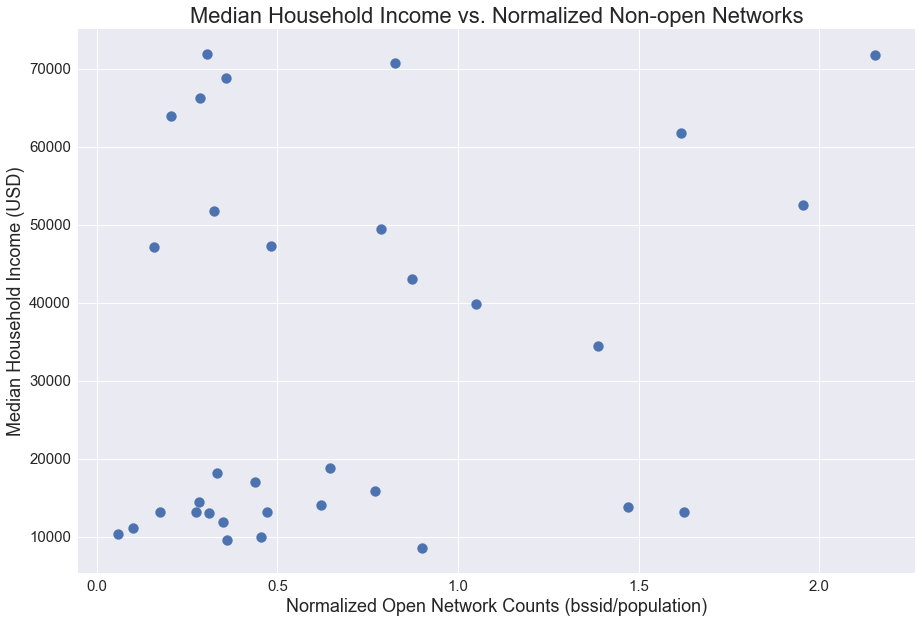

In [421]:
ax = scatter_plot.plot(kind='scatter', figsize=(15, 10), legend=True, fontsize=15,\
                       x='norm_non_open_counts', y='MHI', s=100)
ax.set_title("Median Household Income vs. Normalized Non-open Networks",fontsize=22)
ax.set_xlabel("Normalized Open Network Counts (bssid/population)", fontsize=18)
ax.set_ylabel("Median Household Income (USD)", fontsize=18)
#ax.set_yscale("log")

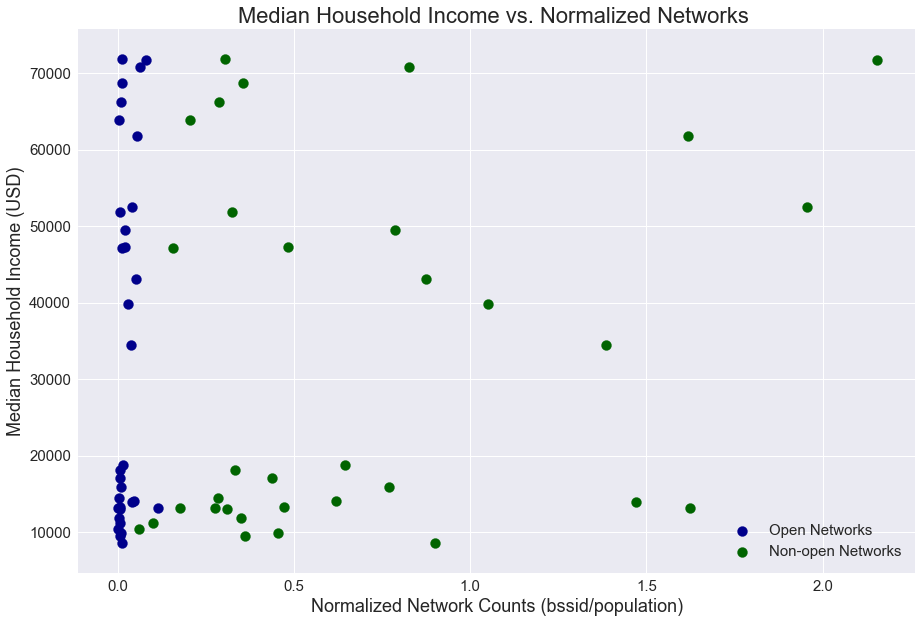

In [422]:
ax = scatter_plot.plot(kind='scatter', figsize=(15, 10), legend=True, fontsize=15,\
                       x='norm_open_counts', y='MHI', s=100, color='DarkBlue',\
                       label='Open Networks')

scatter_plot_box.plot(kind='scatter', figsize=(15, 10), legend=True, fontsize=15,\
                  x='norm_non_open_counts', y='MHI', s=100,\
                  color='DarkGreen', label='Non-open Networks', ax=ax)
ax.set_title("Median Household Income vs. Normalized Networks ",fontsize=22)
ax.set_xlabel("Normalized Network Counts (bssid/population)", fontsize=18)
ax.set_ylabel("Median Household Income (USD)", fontsize=18)
ax.legend()

In [423]:
scatter_plot.columns

Index(['name', 'GEOID', 'MHI', 'norm_open_counts', 'norm_non_open_counts',
       'Public', 'Public_cat', 'target_area_label', 'target_area'],
      dtype='object')

In [424]:
# Open Networks
X = scatter_plot.norm_open_counts
y = scatter_plot.MHI
r1 = scipy.stats.pearsonr(X, y)
print(r1)
print(y.describe())

X = sm.add_constant(X)
model1 = sm.OLS(y, X).fit()

predictions1 = model1.predict(X)
print(predictions1)

model1.summary()

(0.27051165345655948, 0.1278585847212938)
count       33.000000
mean     32732.424242
std      23229.770313
min       8561.000000
25%      13210.000000
50%      18167.000000
75%      51793.000000
max      71875.000000
Name: MHI, dtype: float64
[ 27761.86343191  27898.15696543  29244.55307402  30392.19709899
  29958.21786912  32326.07920528  38172.83263266  28767.3717278
  27639.61040119  29526.68254751  54625.98625041  34091.27116545
  36994.10051053  27927.39283321  30147.18795263  30795.01341612
  28906.20983326  29178.96929954  30217.36534293  28966.97902926
  32218.75578289  28001.90272837  28731.06689004  28418.40856915
  28739.82034563  28748.7443616   29219.20986397  39680.46099365
  42567.32885079  36818.03618338  36564.10518869  46610.00403641
  40314.11561816]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MHI   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.448
Date:                Sun, 30 Jul 2017   Prob (F-statistic):              0.128
Time:                        10:56:18   Log-Likelihood:                -376.82
No. Observations:                  33   AIC:                             757.6
Df Residuals:                      31   BIC:                             760.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const             2.727e+04   5277.382      5.167      0.000      1.65e+04   3.8e+04
norm_open_counts  2.403e+05   1.54e+05      1.564      0.128      -7.3e+04  5.54e+05
==============================================================================
Omnibus:                        4.492   Durbin-Watson:                   0.844
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                2.398
Skew:                           0.409   Prob(JB):                        0.301
Kurtosis:                       1.963   Cond. No.                         38.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [425]:
# Non-Open Networks
X2 = scatter_plot.norm_non_open_counts
y = scatter_plot.MHI
r2 = scipy.stats.pearsonr(X2, y)
print(r2)
print(y.describe())

X2 = sm.add_constant(X2)
model2 = sm.OLS(y, X2).fit()

predictions2 = model2.predict(X2)
print(predictions2)

model2.summary()

(0.25148931455457807, 0.15800895844812576)
count       33.000000
mean     32732.424242
std      23229.770313
min       8561.000000
25%      13210.000000
50%      18167.000000
75%      51793.000000
max      71875.000000
Name: MHI, dtype: float64
[ 26238.3347729   27776.99984924  28619.48632805  29355.65618706
  28800.85963431  30671.15722186  32120.49001341  26659.15203107
  28494.40540168  33674.99462835  42643.81660347  36612.5306533
  41019.38072394  28592.74955522  35054.3759646   32368.10489345
  30211.48911638  29089.75262557  27273.3758725   29013.53332264
  33872.11875634  27457.26523345  28865.59434906  29288.87967826
  29397.40105097  30545.69010373  30389.95525833  34769.21976868
  34277.55877736  46105.39784026  40149.80455412  48186.08163881
  42574.38759165]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MHI   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.093
Date:                Sun, 30 Jul 2017   Prob (F-statistic):              0.158
Time:                        10:56:30   Log-Likelihood:                -376.99
No. Observations:                  33   AIC:                             758.0
Df Residuals:                      31   BIC:                             761.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                 2.561e+04   6325.855      4.049      0.000      1.27e+04  3.85e+04
norm_non_open_counts  1.048e+04   7244.216      1.447      0.158     -4294.244  2.53e+04
==============================================================================
Omnibus:                        6.239   Durbin-Watson:                   0.786
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                3.478
Skew:                           0.584   Prob(JB):                        0.176
Kurtosis:                       1.920   Cond. No.                         2.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [426]:
scatter_plot.head(1)

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,target_area_label,target_area
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,Public Area,3,Redhook


In [427]:
scatter_plot["predictions_open"] = predictions1
scatter_plot["predictions_non_open"] = predictions2

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [428]:
scatter_plot.head()

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,target_area_label,target_area,predictions_open,predictions_non_open
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,Public Area,3,Redhook,27761.863432,26238.334773
1416,Non_Public_RedHook,360470065002,63889,0.002628,0.206307,False,Private Area,3,Redhook,27898.156965,27776.999849
1651,Non_Public_RedHook,360470065003,66181,0.008230,0.286694,False,Private Area,3,Redhook,29244.553074,28619.486328
1986,Non_Public_RedHook,360470065001,68750,0.013006,0.356936,False,Private Area,3,Redhook,30392.197099,29355.656187
2447,Non_Public_RedHook,360470065004,71875,0.011200,0.304000,False,Private Area,3,Redhook,29958.217869,28800.859634


In [429]:
X2.head()

,const,norm_non_open_counts
0,1.0,0.059494
1416,1.0,0.206307
1651,1.0,0.286694
1986,1.0,0.356936
2447,1.0,0.304000


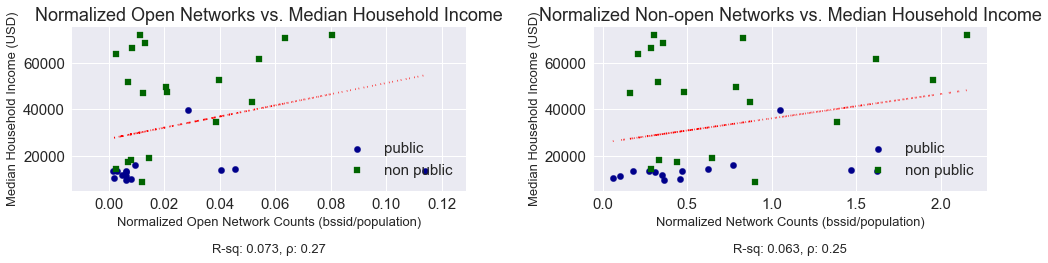

In [431]:
ax1 = plt.subplot(1,2,1)

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=40, color='DarkBlue',\
                      label='public', ax=ax1, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=40, color='DarkGreen',\
                      label='non public', ax=ax1, marker="s")
plt.plot(X.norm_open_counts, predictions1, color="red", linestyle='--', dashes=(.3, 4))

ax1.set_title("Normalized Open Networks vs. Median Household Income",fontsize=18)
ax1.set_xlabel("Normalized Open Network Counts (bssid/population)\n\nR-sq: {:.2}, ρ: {:.2}".format(model1.rsquared,r1[0]),\
               fontsize=13)
ax1.set_ylabel("Median Household Income (USD)", fontsize=13)


ax2 = plt.subplot(1,2,2)

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=40,\
                       color='DarkBlue', label='public', ax=ax2, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=40,\
                       color='DarkGreen', label='non public', ax=ax2, marker="s")
plt.plot(X2.norm_non_open_counts, predictions2, color="red", linestyle='--', dashes=(.3, 4))

ax2.set_title("Normalized Non-open Networks vs. Median Household Income",fontsize=18)
ax2.set_xlabel("Normalized Network Counts (bssid/population)\n\nR-sq: {:.2}, ρ: {:.2}".format(model2.rsquared,r2[0]), fontsize=13)
ax2.set_ylabel("Median Household Income (USD)", fontsize=13)
plt.tight_layout()

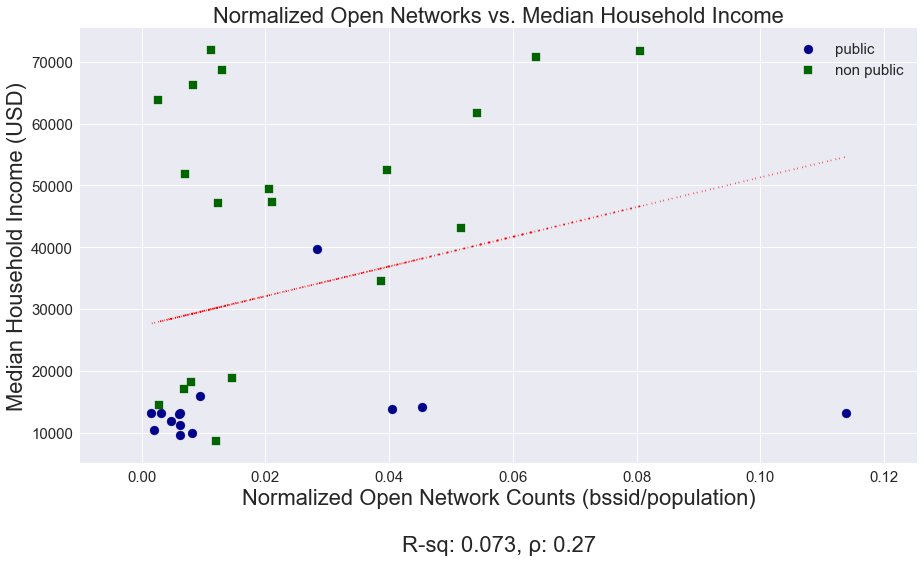

In [432]:
ax1 = plt.subplot()

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 8), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=80, color='DarkBlue',\
                      label='public', ax=ax1, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 8), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=80, color='DarkGreen',\
                      label='non public', ax=ax1, marker="s")
plt.plot(X.norm_open_counts, predictions1, color="red", linestyle='--', dashes=(.3, 4))

ax1.set_title("Normalized Open Networks vs. Median Household Income",fontsize=22)
ax1.set_xlabel("Normalized Open Network Counts (bssid/population)\n\nR-sq: {:.2}, ρ: {:.2}".format(model1.rsquared,r1[0]),\
               fontsize=22)
ax1.set_ylabel("Median Household Income (USD)", fontsize=22)

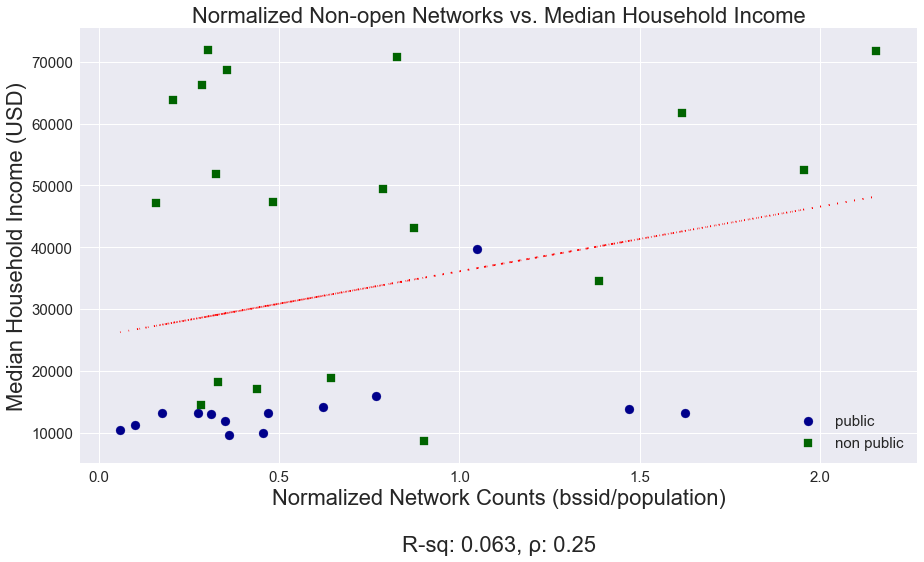

In [433]:
ax2 = plt.subplot()

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 8), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=80,\
                       color='DarkBlue', label='public', ax=ax2, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 8), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=80,\
                       color='DarkGreen', label='non public', ax=ax2, marker="s")
plt.plot(X2.norm_non_open_counts, predictions2, color="red", linestyle='--', dashes=(.3, 4))

ax2.set_title("Normalized Non-open Networks vs. Median Household Income",fontsize=22)
ax2.set_xlabel("Normalized Network Counts (bssid/population)\n\nR-sq: {:.2}, ρ: {:.2}".format(model2.rsquared,r2[0]), fontsize=22)
ax2.set_ylabel("Median Household Income (USD)", fontsize=22)

# Log Transform

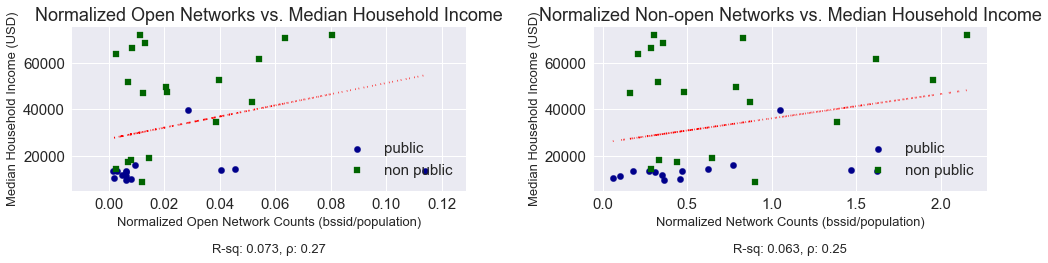

In [435]:
ax1 = plt.subplot(1,2,1)

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=40, color='DarkBlue',\
                      label='public', ax=ax1, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=40, color='DarkGreen',\
                      label='non public', ax=ax1, marker="s")
plt.plot(X.norm_open_counts, predictions1, color="red", linestyle='--', dashes=(.3, 4))

ax1.set_title("Normalized Open Networks vs. Median Household Income",fontsize=18)
ax1.set_xlabel("Normalized Open Network Counts (bssid/population)\n\nR-sq: {:.2}, ρ: {:.2}".format(model1.rsquared,r1[0]),\
               fontsize=13)
ax1.set_ylabel("Median Household Income (USD)", fontsize=13)
#ax1.set_yscale("log")
#ax1.set_xscale("log")


ax2 = plt.subplot(1,2,2)

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=40,\
                       color='DarkBlue', label='public', ax=ax2, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=40,\
                       color='DarkGreen', label='non public', ax=ax2, marker="s")
plt.plot(X2.norm_non_open_counts, predictions2, color="red", linestyle='--', dashes=(.3, 4))

ax2.set_title("Normalized Non-open Networks vs. Median Household Income",fontsize=18)
ax2.set_xlabel("Normalized Network Counts (bssid/population)\n\nR-sq: {:.2}, ρ: {:.2}".format(model2.rsquared,r2[0]), fontsize=13)
ax2.set_ylabel("Median Household Income (USD)", fontsize=13)
#ax2.set_yscale("log")
#ax2.set_xscale("log")
plt.tight_layout()

In [436]:
# transforming normalized counts

In [437]:
log(0.002061)

-6.1845639770738154

In [438]:
list(map(lambda x: log(x), scatter_plot.norm_open_counts))

[-6.1845611770698952,
 -5.9414861773017407,
 -4.7999142627806028,
 -4.3423613782814501,
 -4.4918415006810886,
 -3.8607297110405954,
 -3.0926645137301838,
 -5.0759887005159152,
 -6.4680092368970987,
 -4.6665788141167353,
 -2.1729422341092155,
 -3.5614518444274315,
 -3.2070413672211977,
 -5.8962376971649615,
 -4.4239908337729137,
 -4.2211403585999916,
 -4.9875128766754013,
 -4.8336328987799009,
 -4.3999211245504322,
 -4.9511211665638477,
 -3.8821700422784651,
 -5.7894039973567768,
 -5.1004759980960452,
 -5.340623972772482,
 -5.094516778076958,
 -5.08847778086019,
 -4.8128095507663362,
 -2.9631858667957895,
 -2.7540998867135391,
 -3.2253067151984913,
 -3.2522519860251986,
 -2.5196495982318732,
 -2.9134020051708638]

In [439]:
scatter_plot["log_norm_open_counts"] = list(map(lambda x: log(x), scatter_plot.norm_open_counts))
scatter_plot["log_norm_non_open_counts"] = list(map(lambda x: log(x), scatter_plot.norm_non_open_counts))
scatter_plot["log_MHI"] = list(map(lambda x: log(x), scatter_plot.MHI))

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [440]:
#scatter_plot.to_csv("box_plot_data.csv")

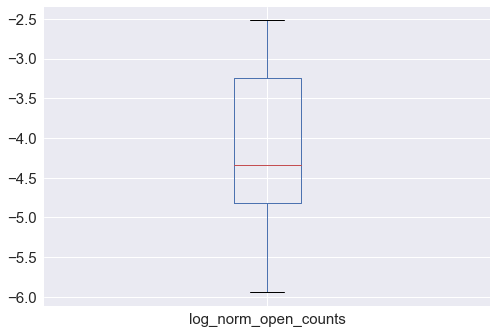

In [441]:
scatter_plot.log_norm_open_counts[scatter_plot.Public ==  False].plot(kind="box")
#scatter_plot.log_norm_open_counts[scatter_plot.Public ==  True].plot(kind="box")
#scatter_plot.log_norm_non_open_counts[scatter_plot.Public ==  False].plot(kind="box")
#scatter_plot.log_norm_non_open_counts[scatter_plot.Public ==  True].plot(kind="box")

In [442]:
scatter_plot.head(1)

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,target_area_label,target_area,predictions_open,predictions_non_open,log_norm_open_counts,log_norm_non_open_counts,log_MHI
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,Public Area,3,Redhook,27761.863432,26238.334773,-6.184561,-2.821874,9.246865


In [446]:
# Move this down to regression

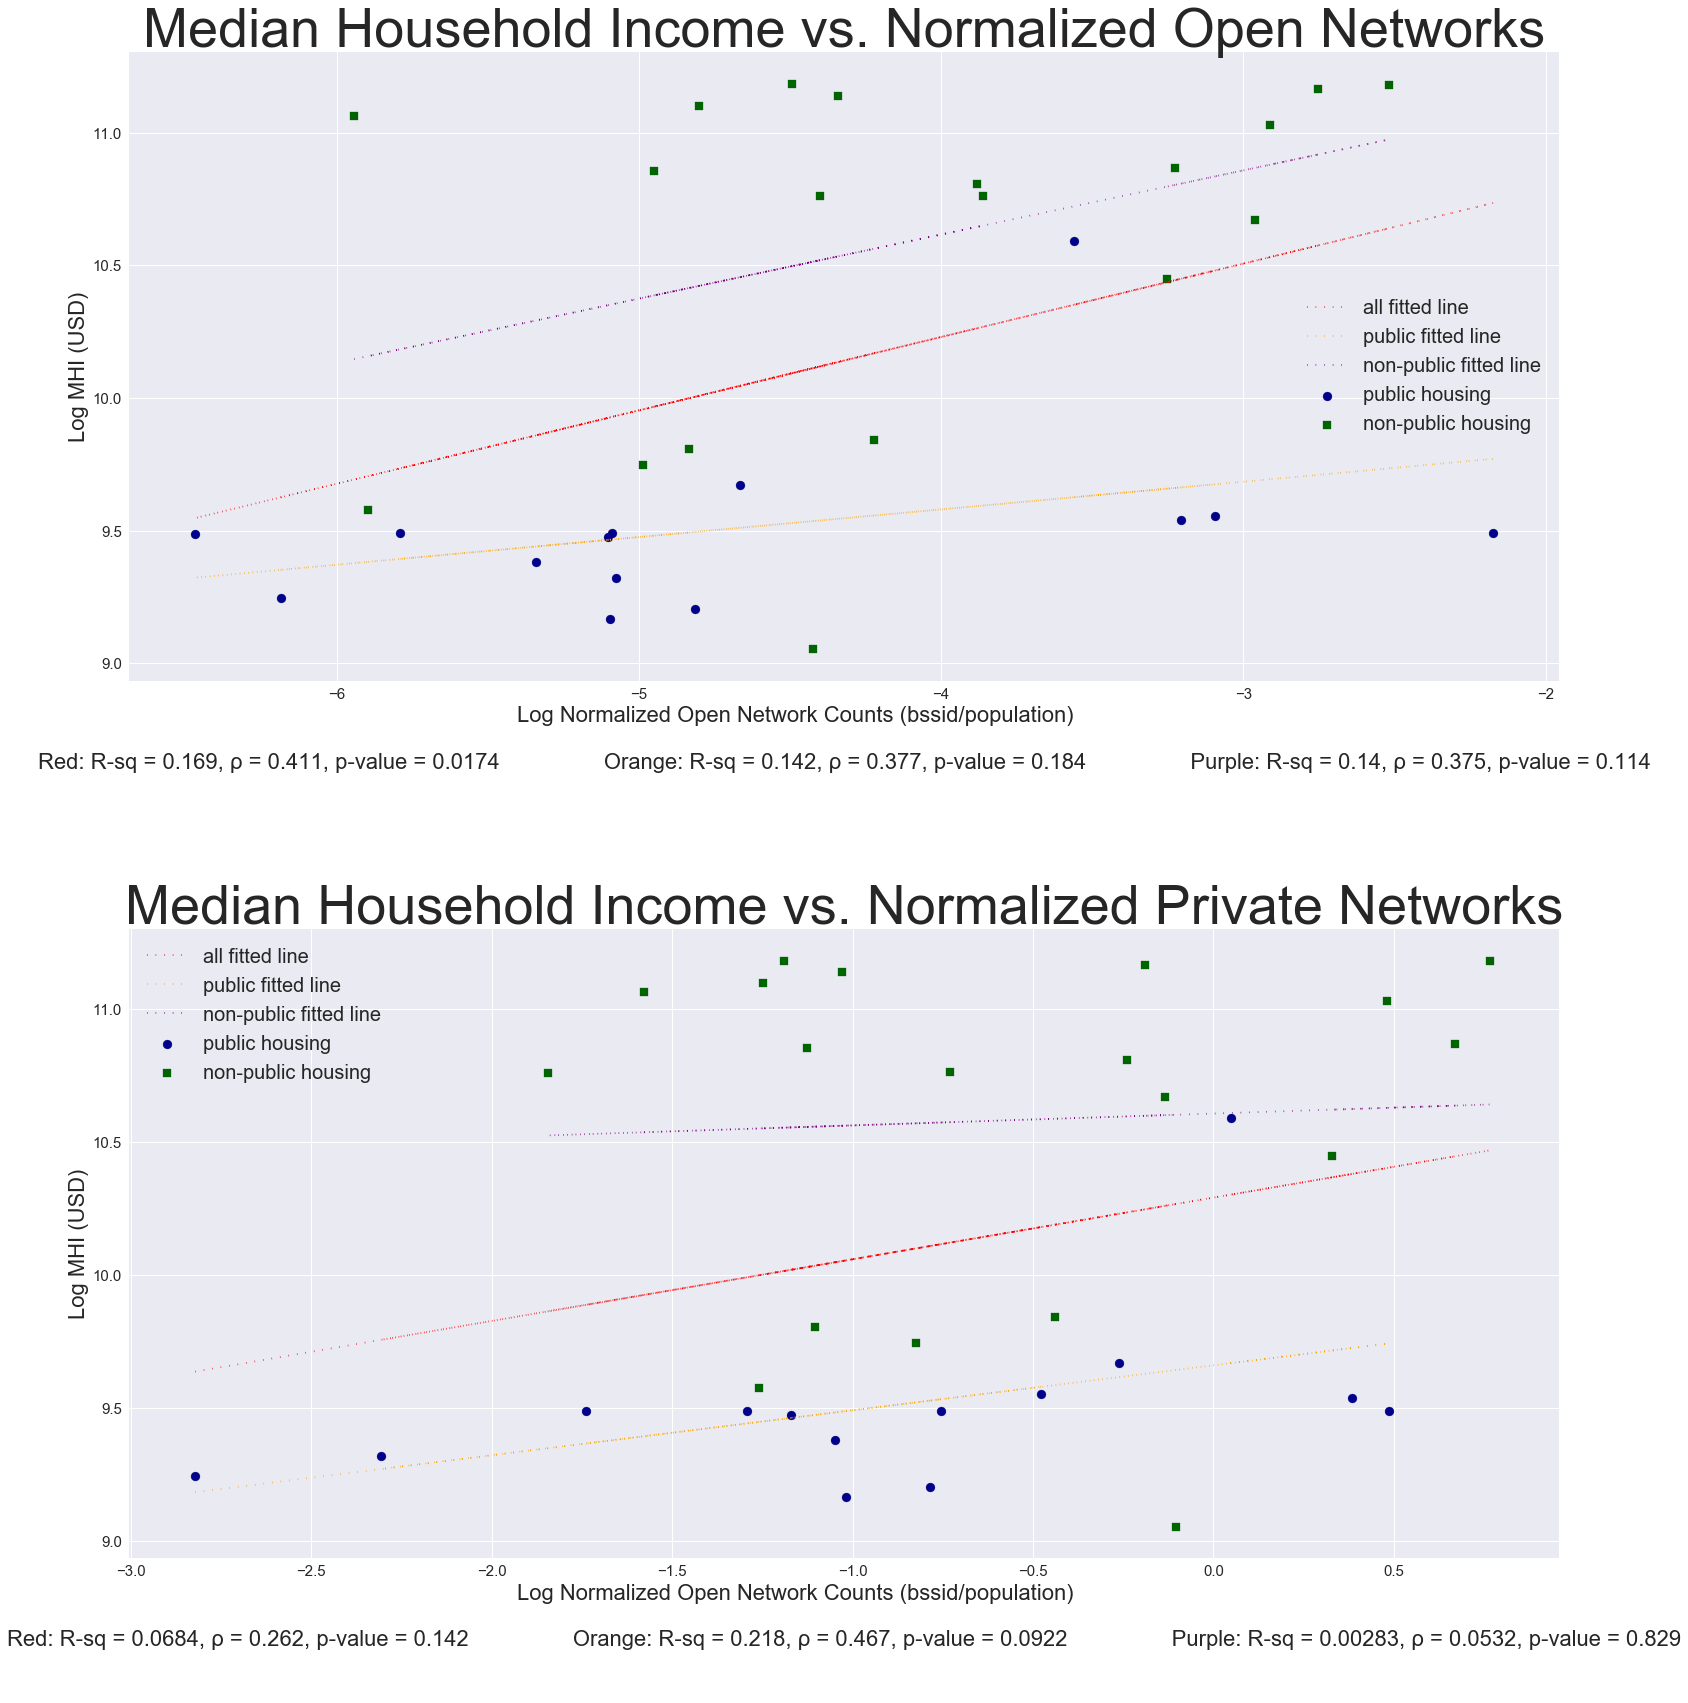

In [455]:
ax1 = plt.subplot(2,1,1)

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(24, 24), legend=True, fontsize=15, x='log_norm_open_counts', \
                  y='log_MHI', s=80, color='DarkBlue',\
                      label='public housing', ax=ax1, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(24, 24), legend=True, fontsize=15, x='log_norm_open_counts', \
                  y='log_MHI', s=80, color='DarkGreen',\
                      label='non-public housing', ax=ax1, marker="s")
plt.plot(X_open.log_norm_open_counts, predictions1_open, color="red", linestyle='--', dashes=(.3, 4), label="all fitted line")
plt.plot(X_open_public.log_norm_open_counts, predictions1_open_public, color="orange", linestyle='--', dashes=(.3, 4), label="public fitted line")
plt.plot(X_non_open_public.log_norm_open_counts, predictions1_non_open_public, color="purple", linestyle='--', dashes=(.3, 4), label="non-public fitted line")

ax1.set_title("Median Household Income vs. Normalized Open Networks",fontsize=54)
ax1.set_xlabel("Log Normalized Open Network Counts (bssid/population)\
                \n\nRed: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3} \
                Orange: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3} \
                Purple: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}\n\n\n\n".format(model1_open.rsquared,r1_open[0],r1_open[1],\
                                                  model1_open_public.rsquared,r1_open_public[0],r1_open_public[1],\
                                                  model1_non_open_public.rsquared,r1_non_open_public[0],r1_non_open_public[1]), fontsize=22)
ax1.set_ylabel("Log MHI (USD)", fontsize=22)
#ax1.set_yscale("log")
#ax1.set_xscale("log")

plt.legend(fontsize=20)
plt.tight_layout()

ax2 = plt.subplot(2,1,2)

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(24, 24), legend=True, fontsize=15, x='log_norm_non_open_counts', y='log_MHI', s=80,\
                       color='DarkBlue', label='public housing', ax=ax2, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(24, 24), legend=True, fontsize=15, x='log_norm_non_open_counts', y='log_MHI', s=80,\
                       color='DarkGreen', label='non-public housing', ax=ax2, marker="s")
plt.plot(X2_non_open.log_norm_non_open_counts, predictions2_non_open, color="red", linestyle='--', dashes=(.3, 4), label="all fitted line")
plt.plot(X2_non_open_public.log_norm_non_open_counts, predictions2_non_open_public, color="orange", linestyle='--', dashes=(.3, 4), label="public fitted line")
plt.plot(X2_non_open_non_public.log_norm_non_open_counts, predictions2_non_open_non_public, color="purple", linestyle='--', dashes=(.3, 4), label="non-public fitted line")

ax2.set_title("Median Household Income vs. Normalized Private Networks",fontsize=54)
ax2.set_xlabel("Log Normalized Open Network Counts (bssid/population)\
                \n\nRed: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3} \
                Orange: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3} \
                Purple: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}\n\n".format(model2_non_open.rsquared,r2_non_open[0],r2_non_open[1],\
                                                  model2_non_open_public.rsquared,r2_non_open_public[0],r2_non_open_public[1],\
                                                  model2_non_open_non_public.rsquared,r2_non_open_non_public[0],r2_non_open_non_public[1]), fontsize=22)
ax2.set_ylabel("Log MHI (USD)", fontsize=22)
#ax2.set_yscale("log")
#ax2.set_xscale("log")
plt.legend(fontsize=20)
plt.tight_layout()

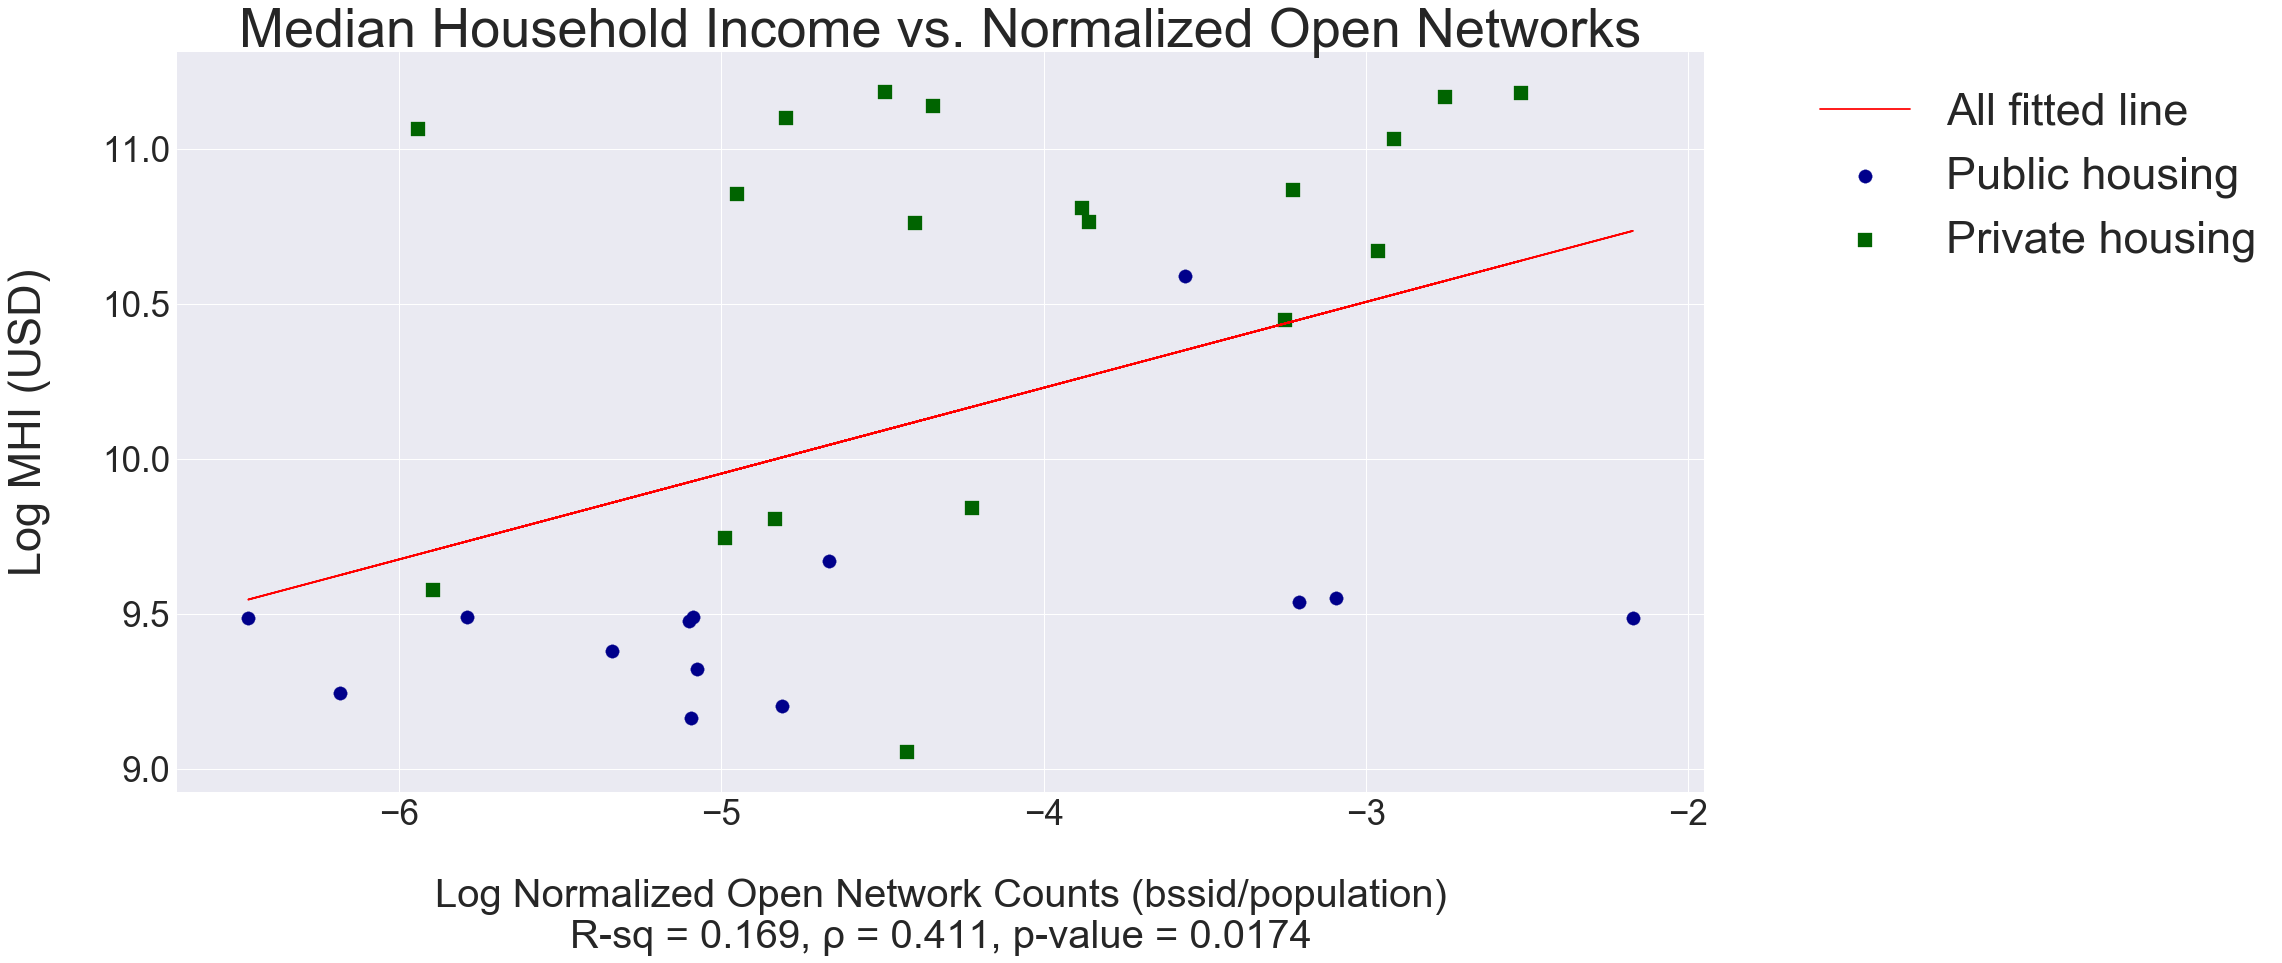

In [578]:
ax1 = plt.subplot(2,1,1)

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(24, 24), legend=True, fontsize=15, x='log_norm_open_counts', \
                  y='log_MHI', s=180, color='DarkBlue',\
                      label='Public housing', ax=ax1, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(24, 24), legend=True, fontsize=15, x='log_norm_open_counts', \
                  y='log_MHI', s=180, color='DarkGreen',\
                      label='Private housing', ax=ax1, marker="s")
plt.plot(X_open.log_norm_open_counts, predictions1_open, color="red", linestyle='-', label="All fitted line")
#plt.plot(X_open_public.log_norm_open_counts, predictions1_open_public, color="orange", linestyle='-.', dashes=(3, 4), label="Public fitted line")
#plt.plot(X_non_open_public.log_norm_open_counts, predictions1_non_open_public, color="purple", linestyle='--', dashes=(3, 4), label="Private fitted line")

ax1.set_title("Median Household Income vs. Normalized Open Networks",fontsize=54)
ax1.set_xlabel("\nLog Normalized Open Network Counts (bssid/population)\
\nR-sq = {:.3}, ρ = {:.3}, p-value = {:.3}".format(model1_open.rsquared,r1_open[0],r1_open[1]), fontsize=40)
ax1.set_ylabel("Log MHI (USD)\n", fontsize=45)
#ax1.set_yscale("log")
#ax1.set_xscale("log")

plt.legend(fontsize=45)
plt.tight_layout()
ax1.tick_params(axis='both', labelsize=35)
plt.xticks(rotation = 0)
plt.legend(loc='upper left', fontsize=45, bbox_to_anchor=(1.05, 1))

In [533]:
"""Red: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}
Orange: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}
Purple: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}""".format(model1_open.rsquared,r1_open[0],r1_open[1],\
                                                  model1_open_public.rsquared,r1_open_public[0],r1_open_public[1],\
                                                  model1_non_open_public.rsquared,r1_non_open_public[0],r1_non_open_public[1])


'Red: R-sq = 0.169, ρ = 0.411, p-value = 0.0174\nOrange: R-sq = 0.142, ρ = 0.377, p-value = 0.184\nPurple: R-sq = 0.14, ρ = 0.375, p-value = 0.114'

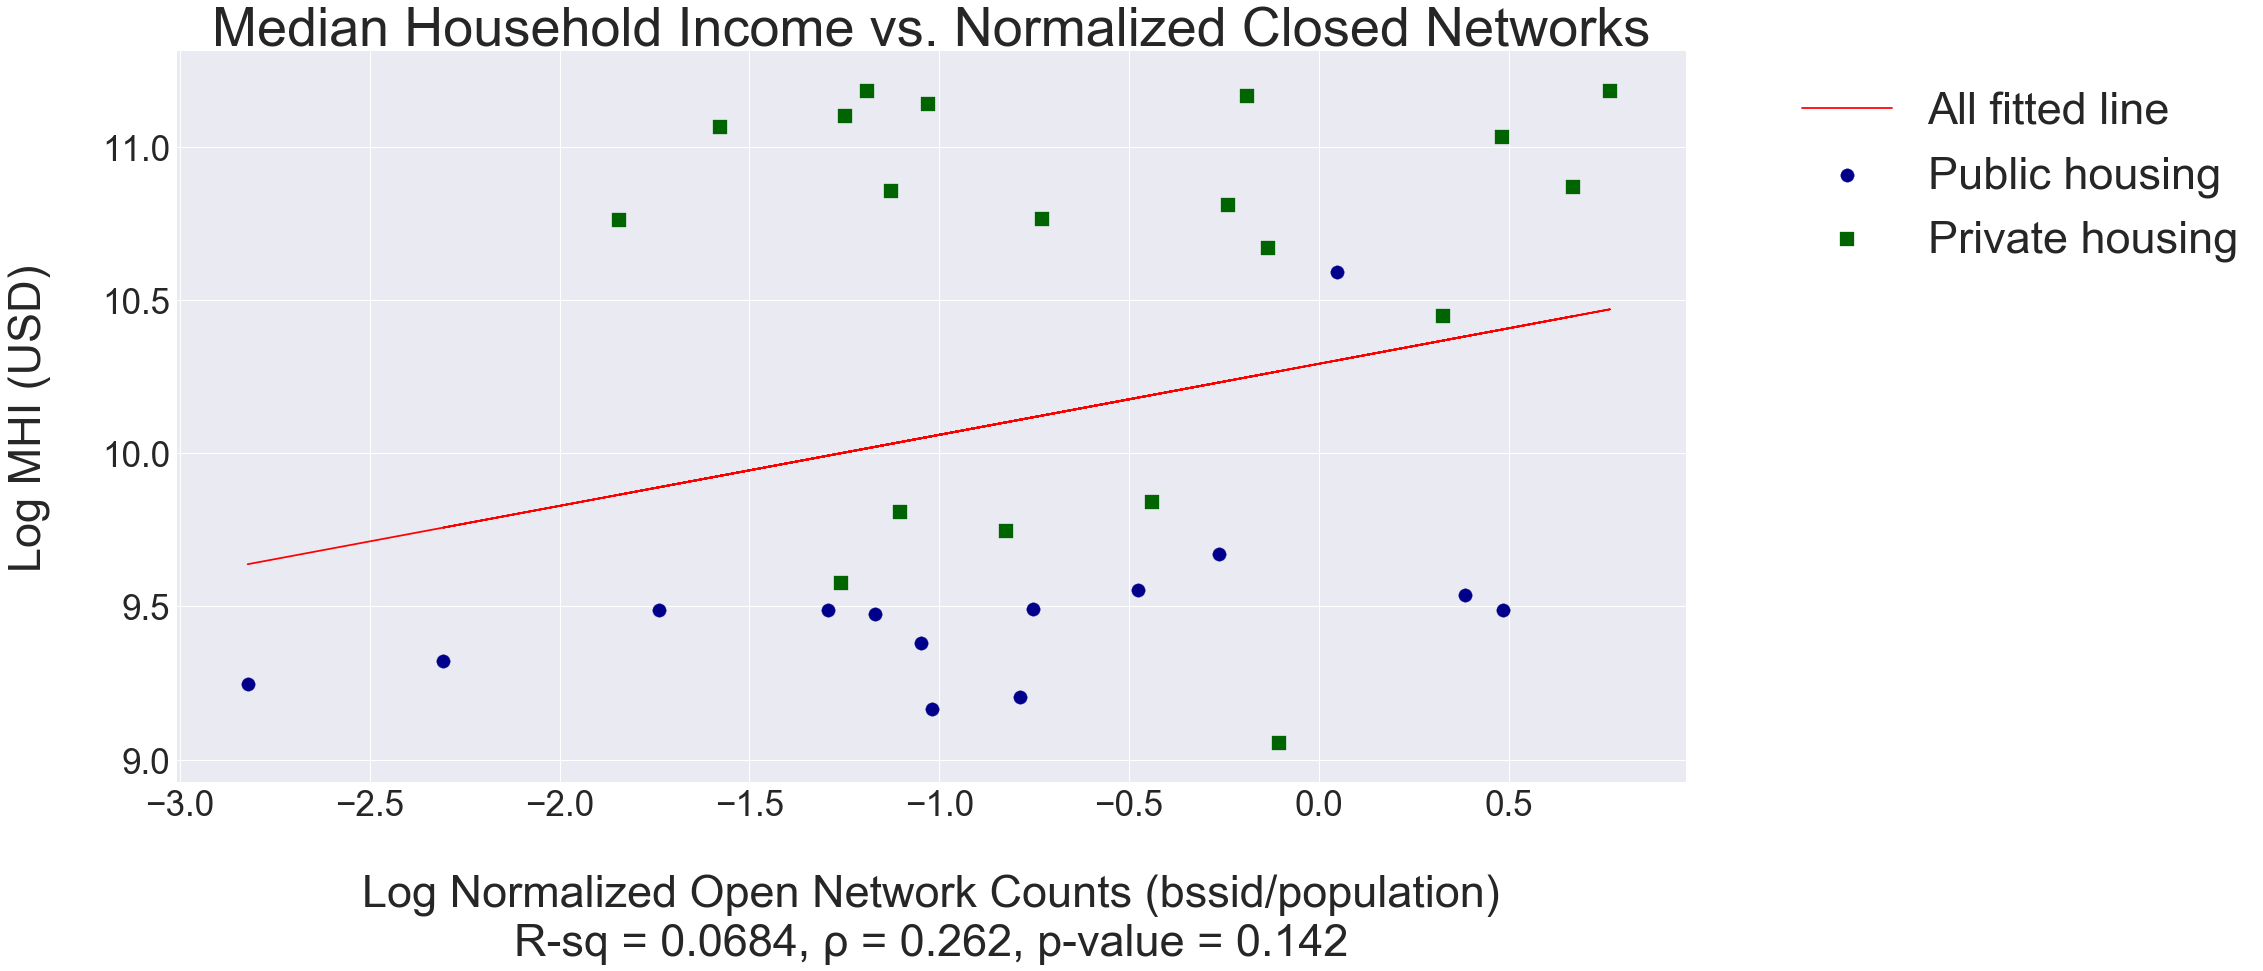

In [579]:
ax2 = plt.subplot(2,1,2)

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(24, 24), legend=True, fontsize=15, x='log_norm_non_open_counts', y='log_MHI', s=180,\
                       color='DarkBlue', label='Public housing', ax=ax2, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(24, 24), legend=True, fontsize=15, x='log_norm_non_open_counts', y='log_MHI', s=180,\
                       color='DarkGreen', label='Private housing', ax=ax2, marker="s")
plt.plot(X2_non_open.log_norm_non_open_counts, predictions2_non_open, color="red", linestyle='-', label="All fitted line")
#plt.plot(X2_non_open_public.log_norm_non_open_counts, predictions2_non_open_public, color="orange", linestyle='--', dashes=(3, 4), label="Public fitted line")
#plt.plot(X2_non_open_non_public.log_norm_non_open_counts, predictions2_non_open_non_public, color="purple", linestyle='--', dashes=(3, 4), label="Private fitted line")

ax2.set_title("Median Household Income vs. Normalized Closed Networks",fontsize=54)
ax2.set_xlabel("\nLog Normalized Open Network Counts (bssid/population)\
\nR-sq = {:.3}, ρ = {:.3}, p-value = {:.3}".format(model2_non_open.rsquared,r2_non_open[0],r2_non_open[1]), fontsize=45)
ax2.set_ylabel("Log MHI (USD)\n", fontsize=45)
#ax2.set_yscale("log")
#ax2.set_xscale("log")

plt.legend(fontsize=45)
plt.tight_layout()
ax2.tick_params(axis='both', labelsize=35)
plt.xticks(rotation = 0)
plt.legend(loc='upper left', fontsize=45, bbox_to_anchor=(1.05, 1))

In [539]:
"""Red: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3} \
Orange: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3} \
Purple: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}""".format(model2_non_open.rsquared,r2_non_open[0],r2_non_open[1],\
                                                  model2_non_open_public.rsquared,r2_non_open_public[0],r2_non_open_public[1],\
                                                  model2_non_open_non_public.rsquared,r2_non_open_non_public[0],r2_non_open_non_public[1])


'Red: R-sq = 0.0684, ρ = 0.262, p-value = 0.142 Orange: R-sq = 0.218, ρ = 0.467, p-value = 0.0922 Purple: R-sq = 0.00283, ρ = 0.0532, p-value = 0.829'

In [456]:
# Without logging the data

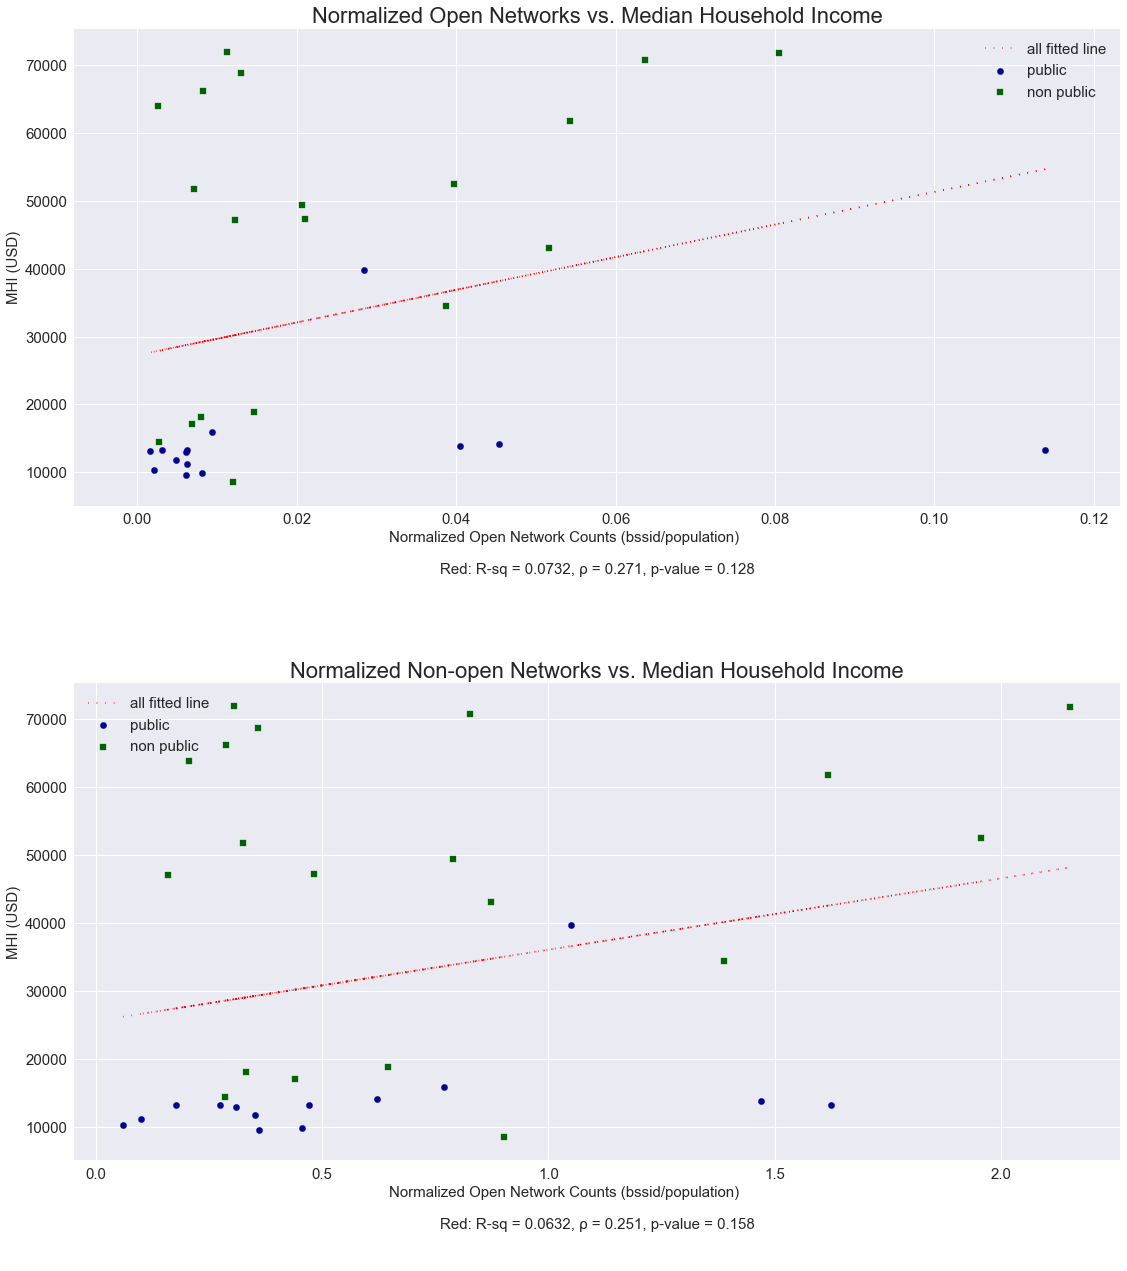

In [465]:
ax1 = plt.subplot(2,1,1)

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(16, 18), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=40, color='DarkBlue',\
                      label='public', ax=ax1, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(16, 18), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=40, color='DarkGreen',\
                      label='non public', ax=ax1, marker="s")
plt.plot(X.norm_open_counts, predictions1, color="red", linestyle='--', dashes=(.3, 4), label="all fitted line")
#plt.plot(X_open_public.log_norm_open_counts, predictions1_open_public, color="orange", linestyle='--', dashes=(.3, 4), label="public fitted line")
#plt.plot(X_non_open_public.log_norm_open_counts, predictions1_non_open_public, color="purple", linestyle='--', dashes=(.3, 4), label="non-public fitted line")

ax1.set_title("Normalized Open Networks vs. Median Household Income",fontsize=22)
ax1.set_xlabel("Normalized Open Network Counts (bssid/population)\
                \n\nRed: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}\n\n\n\n".format(model1.rsquared,r1[0],r1[1]), fontsize=15)
ax1.set_ylabel("MHI (USD)", fontsize=15)
#ax1.set_yscale("log")
#ax1.set_xscale("log")

plt.legend(fontsize=15)
plt.tight_layout()

ax2 = plt.subplot(2,1,2)

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(16, 18), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=40,\
                       color='DarkBlue', label='public', ax=ax2, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(16, 18), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=40,\
                       color='DarkGreen', label='non public', ax=ax2, marker="s")
plt.plot(X2.norm_non_open_counts, predictions2, color="red", linestyle='--', dashes=(.3, 4), label="all fitted line")
#plt.plot(X2_non_open_public.log_norm_non_open_counts, predictions2_non_open_public, color="orange", linestyle='--', dashes=(.3, 4), label="public fitted line")
#plt.plot(X2_non_open_non_public.log_norm_non_open_counts, predictions2_non_open_non_public, color="purple", linestyle='--', dashes=(.3, 4), label="non-public fitted line")

ax2.set_title("Normalized Non-open Networks vs. Median Household Income",fontsize=22)
ax2.set_xlabel("Normalized Open Network Counts (bssid/population)\
                \n\nRed: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}\n\n".format(model2.rsquared,r2[0],r2[1]), fontsize=15)
ax2.set_ylabel("MHI (USD)", fontsize=15)
#ax2.set_yscale("log")
#ax2.set_xscale("log")
plt.legend(fontsize=15)
plt.tight_layout()

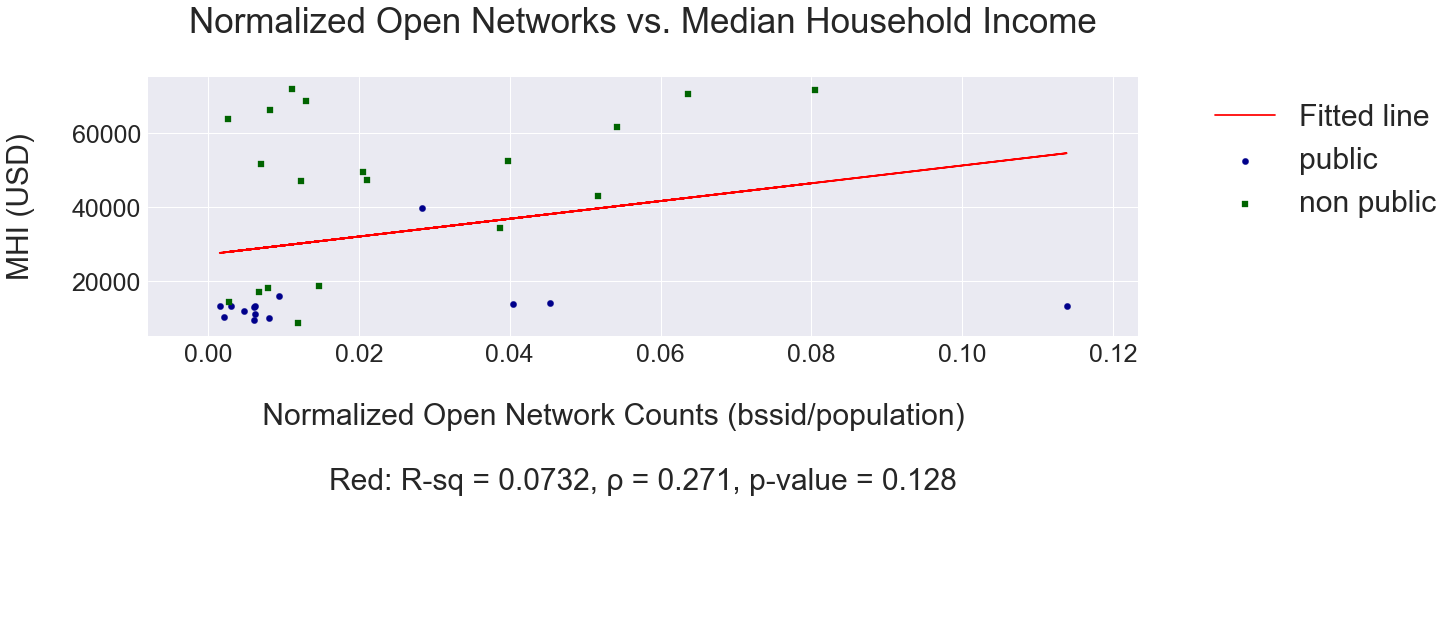

In [473]:
ax1 = plt.subplot(1,1,1)

scatter_plot[scatter_plot.Public_cat == "Public Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(16, 9), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=40, color='DarkBlue',\
                      label='public', ax=ax1, marker="o")
scatter_plot[scatter_plot.Public_cat == "Private Area"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(16, 9), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=40, color='DarkGreen',\
                      label='non public', ax=ax1, marker="s")
plt.plot(X.norm_open_counts, predictions1, color="red", linestyle='-', label="Fitted line")
#plt.plot(X_open_public.log_norm_open_counts, predictions1_open_public, color="orange", linestyle='--', dashes=(.3, 4), label="public fitted line")
#plt.plot(X_non_open_public.log_norm_open_counts, predictions1_non_open_public, color="purple", linestyle='--', dashes=(.3, 4), label="non-public fitted line")

ax1.set_title("Normalized Open Networks vs. Median Household Income\n",fontsize=35)
ax1.set_xlabel("\n         Normalized Open Network Counts (bssid/population)\
                \n\nRed: R-sq = {:.3}, ρ = {:.3}, p-value = {:.3}\n\n\n\n".format(model1.rsquared,r1[0],r1[1]), fontsize=30)
ax1.set_ylabel("MHI (USD)\n", fontsize=30)
#ax1.set_yscale("log")
#ax1.set_xscale("log")

plt.legend(fontsize=25)
plt.tight_layout()
ax1.tick_params(axis='both', labelsize=25)
plt.xticks(rotation = 0)
plt.legend(loc='upper left', fontsize=30, bbox_to_anchor=(1.05, 1))

In [392]:
# Regression lines (3 per plot)

# Open Networks Regression

In [448]:
# move this up to scatter plots

In [449]:
# Open Networks all
X_open = scatter_plot.log_norm_open_counts
y = scatter_plot.log_MHI
r1_open = scipy.stats.pearsonr(X_open, y)
print(r1_open)
print(y.describe())

X_open = sm.add_constant(X_open)
model1_open = sm.OLS(y, X_open).fit()

predictions1_open = model1_open.predict(X_open)
print(predictions1_open)

#model1_open.summary()

(0.41123033995547642, 0.017429844268502449)
count    33.000000
mean     10.126517
std       0.758471
min       9.054972
25%       9.488729
50%       9.807362
75%      10.855010
max      11.182684
Name: log_MHI, dtype: float64
[  9.62508864   9.6923775   10.00839141  10.13505279  10.09367318
  10.26837974  10.48099822   9.93196752   9.54662356  10.04530179
  10.73559894  10.35122688  10.44933602   9.70490335  10.11245584
  10.16860961   9.95645971   9.9990573   10.1191189    9.96653379
  10.26244456   9.73447742   9.92518887   9.85871027   9.92683852
   9.92851025  10.00482169  10.51684095  10.57472086  10.44427975
  10.43682066  10.6396222   10.53062229]


In [450]:
# Open Networks - public block groups - blue points
X_open_public = scatter_plot[scatter_plot.Public == True].log_norm_open_counts
y = scatter_plot[scatter_plot.Public == True].log_MHI
r1_open_public = scipy.stats.pearsonr(X_open_public, y)
print(r1_open_public)
print(y.describe())

X_open_public = sm.add_constant(X_open_public)
model1_open_public = sm.OLS(y, X_open_public).fit()

predictions1_open_public = model1_open_public.predict(X_open_public)
print(predictions1_open_public)

#model1_open_public.summary()

(0.37733508036514779, 0.18350613765258231)
count    14.000000
mean      9.507664
std       0.343576
min       9.165657
25%       9.336957
50%       9.488427
75%       9.526681
max      10.591321
Name: log_MHI, dtype: float64
[ 9.35158209  9.67441045  9.46732938  9.32198697  9.51007632  9.77043968
  9.62546385  9.66246824  9.39284089  9.46477263  9.43969851  9.46539484
  9.46602538  9.4948082 ]


In [451]:
# Open Networks - non-public block groups - green squares
X_non_open_public = scatter_plot[scatter_plot.Public == False].log_norm_open_counts
y = scatter_plot[scatter_plot.Public == False].log_MHI
r1_non_open_public = scipy.stats.pearsonr(X_non_open_public, y)
print(r1_non_open_public)
print(y.describe())

X_non_open_public = sm.add_constant(X_non_open_public)
model1_non_open_public = sm.OLS(y, X_non_open_public).fit()

predictions1_non_open_public = model1_non_open_public.predict(X_non_open_public)
print(predictions1_non_open_public)

#model1_non_open_public.summary()

(0.3748271956476843, 0.11383305756085892)
count    19.000000
mean     10.582513
std       0.648156
min       9.054972
25%      10.145376
50%      10.808596
75%      11.082526
max      11.182684
Name: log_MHI, dtype: float64
[ 10.14662439  10.4228397   10.53354943  10.49738114  10.65008527
  10.15757273  10.51379833  10.56288013  10.37744825  10.41468113
  10.51962225  10.3862536   10.64489756  10.86725543  10.91784598
  10.80383254  10.79731285  10.97457369  10.87930116]


# Non-open Networks Regression

In [452]:
# Non-open Networks All
X2_non_open = scatter_plot.log_norm_non_open_counts
y = scatter_plot.log_MHI
r2_non_open = scipy.stats.pearsonr(X2_non_open, y)
print(r2_non_open)
print(y.describe())

X2_non_open = sm.add_constant(X2_non_open)
model2_non_open = sm.OLS(y, X2_non_open).fit()

predictions2_non_open = model2_non_open.predict(X2_non_open)
print(predictions2_non_open)

#model2_non_open.summary()

(0.26152899830896226, 0.14151637077223855)
count    33.000000
mean     10.126517
std       0.758471
min       9.054972
25%       9.488729
50%       9.807362
75%      10.855010
max      11.182684
Name: log_MHI, dtype: float64
[  9.63792799   9.92612007  10.00238072  10.05316934  10.01596469
  10.12300655  10.18141766   9.75745953   9.99252622  10.23107504
  10.4044283   10.30309525  10.38119332  10.00030919  10.2676872
  10.19007508  10.10091733  10.03608069   9.86466438  10.03094066
  10.23667492   9.88903308  10.02062646  10.04899488  10.05574129
  10.11718312  10.10974519  10.26057808  10.24778402  10.44731516
  10.3677268   10.46972933  10.40348145]


In [453]:
# Non-open Networks - public block groups - blue points
X2_non_open_public = scatter_plot[scatter_plot.Public == True].log_norm_non_open_counts
y = scatter_plot[scatter_plot.Public == True].log_MHI
r2_non_open_public = scipy.stats.pearsonr(X2_non_open_public, y)
print(r2_non_open_public)
print(y.describe())

X2_non_open_public = sm.add_constant(X2_non_open_public)
model2_non_open_public = sm.OLS(y, X2_non_open_public).fit()

predictions2_non_open_public = model2_non_open_public.predict(X2_non_open_public)
print(predictions2_non_open_public)

#model2_non_open_public.summary()

(0.46707723422821656, 0.0922077693134251)
count    14.000000
mean      9.507664
std       0.343576
min       9.165657
25%       9.336957
50%       9.488427
75%       9.526681
max      10.591321
Name: log_MHI, dtype: float64
[ 9.18480066  9.5810647   9.27195236  9.44334196  9.61727041  9.7436641
  9.6697811   9.72672323  9.36788402  9.46383014  9.48451386  9.48943273
  9.53423062  9.52880754]


In [454]:
# Non-open Networks - non-public block groups - green squares
X2_non_open_non_public = scatter_plot[scatter_plot.Public == False].log_norm_non_open_counts
y = scatter_plot[scatter_plot.Public == False].log_MHI
r2_non_open_non_public = scipy.stats.pearsonr(X2_non_open_non_public, y)
print(r2_non_open_non_public)
print(y.describe())

X2_non_open_non_public = sm.add_constant(X2_non_open_non_public)
model2_non_open_non_public = sm.OLS(y, X2_non_open_non_public).fit()

predictions2_non_open_non_public = model2_non_open_non_public.predict(X2_non_open_non_public)
print(predictions2_non_open_non_public)

#model2_non_open_non_public.summary()

(0.053171657987725274, 0.82884161920848098)
count    19.000000
mean     10.582513
std       0.648156
min       9.054972
25%      10.145376
50%      10.808596
75%      11.082526
max      11.182684
Name: log_MHI, dtype: float64
[ 10.53750244  10.55216387  10.5619282   10.55477545  10.5753547
  10.55176561  10.60317017  10.58824891  10.57110795  10.55864283
  10.52568732  10.55765464  10.59720793  10.60180341  10.5993437
  10.63770441  10.62240321  10.64201363  10.62927719]


# Poisson Regression

In [399]:
housing_wifi_counts_normalized

,open_net_counts,non_open_net_counts,name,Population,norm_open_counts,norm_non_open_counts
0,129.0,2043.0,Non_Public_Chelsea,1723,0.074869,1.185723
1,32.0,1033.0,Non_Public_Gowanus,733,0.043656,1.409277
2,29.0,838.0,Non_Public_RedHook,761,0.038108,1.101183
3,30.0,1485.0,Non_Public_Tompkins,1091,0.027498,1.361137
4,100.0,3566.0,Non_Public_Whitman,780,0.128205,4.571795
5,259.0,5515.0,Public_Chelsea,1546,0.167529,3.567270
6,14.0,1614.0,Public_Gowanus,3221,0.004346,0.501087
7,15.0,433.0,Public_RedHook,7278,0.002061,0.059494
8,49.0,3085.0,Public_Tompkins,3595,0.013630,0.858136
9,42.0,670.0,Public_Whitman,617,0.068071,1.085900


In [400]:
scatter_plot

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,predictions_open,predictions_non_open,log_norm_open_counts,log_norm_non_open_counts,log_MHI
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,public,27761.863432,26238.334773,-6.184561,-2.821874,9.246865
1416,Non_Public_RedHook,360470065002,63889,0.002628,0.206307,False,non-public,27898.156965,27776.999849,-5.941486,-1.578388,11.064902
1651,Non_Public_RedHook,360470065003,66181,0.008230,0.286694,False,non-public,29244.553074,28619.486328,-4.799914,-1.249339,11.100149
1986,Non_Public_RedHook,360470065001,68750,0.013006,0.356936,False,non-public,30392.197099,29355.656187,-4.342361,-1.030198,11.138232
2447,Non_Public_RedHook,360470065004,71875,0.011200,0.304000,False,non-public,29958.217869,28800.859634,-4.491842,-1.190728,11.182684
2844,Non_Public_RedHook,360470065005,47260,0.021053,0.482456,False,non-public,32326.079205,30671.157222,-3.860730,-0.728865,10.763420
3431,Public_Whitman,360470029012,14091,0.045381,0.620746,True,public,38172.832633,32120.490013,-3.092665,-0.476834,9.553292
4870,Public_Whitman,360470029011,11185,0.006245,0.099647,True,public,28767.371728,26659.152031,-5.075989,-2.306121,9.322329
6320,Public_Gowanus,360470071003,13202,0.001552,0.274759,True,public,27639.610401,28494.405402,-6.468009,-1.291860,9.488124
22628,Public_Gowanus,360470127003,15868,0.009404,0.769070,True,public,29526.682548,33674.994628,-4.666579,-0.262573,9.672060


In [401]:
final_data = housing_wifi_counts_normalized.merge(scatter_plot, on="name")

In [402]:
final_data["norm_open_counts"] = final_data.norm_open_counts_x
final_data["norm_non_open_counts"] = final_data.norm_non_open_counts_x
del final_data["norm_open_counts_x"]
del final_data["norm_non_open_counts_x"]
del final_data["norm_open_counts_y"]
del final_data["norm_non_open_counts_y"]

In [403]:
final_data

,open_net_counts,non_open_net_counts,name,Population,GEOID,MHI,Public,Public_cat,predictions_open,predictions_non_open,log_norm_open_counts,log_norm_non_open_counts,log_MHI,norm_open_counts,norm_non_open_counts
0,129.0,2043.0,Non_Public_Chelsea,1723,360610091002,43071,False,non-public,39680.460994,34769.219769,-2.963186,-0.135274,10.670605,0.074869,1.185723
1,129.0,2043.0,Non_Public_Chelsea,1723,360610091003,70741,False,non-public,42567.328851,34277.558777,-2.754100,-0.190478,11.166781,0.074869,1.185723
2,32.0,1033.0,Non_Public_Gowanus,733,360470043004,47125,False,non-public,30217.365343,27273.375873,-4.399921,-1.843556,10.760559,0.043656,1.409277
3,32.0,1033.0,Non_Public_Gowanus,733,360470069004,51793,False,non-public,28966.979029,29013.533323,-4.951121,-1.126110,10.855010,0.043656,1.409277
4,32.0,1033.0,Non_Public_Gowanus,733,360470069003,49444,False,non-public,32218.755783,33872.118756,-3.882170,-0.238411,10.808596,0.043656,1.409277
5,29.0,838.0,Non_Public_RedHook,761,360470065002,63889,False,non-public,27898.156965,27776.999849,-5.941486,-1.578388,11.064902,0.038108,1.101183
6,29.0,838.0,Non_Public_RedHook,761,360470065003,66181,False,non-public,29244.553074,28619.486328,-4.799914,-1.249339,11.100149,0.038108,1.101183
7,29.0,838.0,Non_Public_RedHook,761,360470065001,68750,False,non-public,30392.197099,29355.656187,-4.342361,-1.030198,11.138232,0.038108,1.101183
8,29.0,838.0,Non_Public_RedHook,761,360470065004,71875,False,non-public,29958.217869,28800.859634,-4.491842,-1.190728,11.182684,0.038108,1.101183
9,29.0,838.0,Non_Public_RedHook,761,360470065005,47260,False,non-public,32326.079205,30671.157222,-3.860730,-0.728865,10.763420,0.038108,1.101183


In [404]:
#dummies = pd.get_dummies(df['Category'])
area_dummies = pd.get_dummies(final_data['name'])
area_dummies["name"] = final_data.name
area_dummies

,Non_Public_Chelsea,Non_Public_Gowanus,Non_Public_RedHook,Non_Public_Tompkins,Non_Public_Whitman,Public_Chelsea,Public_Gowanus,Public_RedHook,Public_Tompkins,Public_Whitman,name
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non_Public_Chelsea
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non_Public_Chelsea
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non_Public_Gowanus
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non_Public_Gowanus
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non_Public_Gowanus
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non_Public_RedHook
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non_Public_RedHook
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non_Public_RedHook
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non_Public_RedHook
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non_Public_RedHook


In [405]:
final_data = final_data.merge(area_dummies, on="name")

In [ ]:
# 1 = public housing, 0 = non public housing
final_data["Public"] = [1.,0.,1.,0.,1.,0.,1.,1.,0.]
final_data["Public_cat"] = ["public","non_public","public","non_public",\
                            "public","non_public","public","public","non_public"]

In [407]:
final_data

,open_net_counts,non_open_net_counts,name,Population,GEOID,MHI,Public,Public_cat,predictions_open,predictions_non_open,...,Non_Public_Chelsea,Non_Public_Gowanus,Non_Public_RedHook,Non_Public_Tompkins,Non_Public_Whitman,Public_Chelsea,Public_Gowanus,Public_RedHook,Public_Tompkins,Public_Whitman
0,129.0,2043.0,Non_Public_Chelsea,1723,360610091002,43071,False,non-public,39680.460994,34769.219769,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,129.0,2043.0,Non_Public_Chelsea,1723,360610091002,43071,False,non-public,39680.460994,34769.219769,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,129.0,2043.0,Non_Public_Chelsea,1723,360610091003,70741,False,non-public,42567.328851,34277.558777,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,129.0,2043.0,Non_Public_Chelsea,1723,360610091003,70741,False,non-public,42567.328851,34277.558777,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32.0,1033.0,Non_Public_Gowanus,733,360470043004,47125,False,non-public,30217.365343,27273.375873,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,32.0,1033.0,Non_Public_Gowanus,733,360470043004,47125,False,non-public,30217.365343,27273.375873,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,32.0,1033.0,Non_Public_Gowanus,733,360470043004,47125,False,non-public,30217.365343,27273.375873,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,32.0,1033.0,Non_Public_Gowanus,733,360470069004,51793,False,non-public,28966.979029,29013.533323,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,32.0,1033.0,Non_Public_Gowanus,733,360470069004,51793,False,non-public,28966.979029,29013.533323,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,32.0,1033.0,Non_Public_Gowanus,733,360470069004,51793,False,non-public,28966.979029,29013.533323,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
Data = final_data[["Public", "Public_cat","name","Population","open_net_counts","non_open_net_counts","MHI",\
                  "Chelsea","Chelsea_None","Gowanus","Gowanus_None","Ingersoll","Ingersoll_None",\
                   "RedHook","Tompkins","Tompkins_None", "norm_open_counts", "norm_non_open_counts"]]

In [ ]:
# should I add population density and household desity???????
Data

In [ ]:
final_data.columns

In [ ]:
Data.columns


In [ ]:
#poisson model and negetive binomial model
#not needed to normalize by pop

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import (Exchangeable,
    Independence,Autoregressive)
from statsmodels.genmod.families import Poisson

In [ ]:
# left Redhook out for comperison
# raw counts
fam = Poisson()
ind = Independence()
model1 = GEE.from_formula("Public ~ Population + open_net_counts + non_open_net_counts \
                            + MHI + Chelsea + Chelsea_None + Gowanus + Gowanus_None \
                            + Ingersoll + Ingersoll_None + Tompkins \
                            + Tompkins_None", "name", data=Data, cov_struct=ind, family=fam)
result1 = model1.fit()
print(result1.summary())

In [ ]:
result1.predict()

In [ ]:
# left Redhook out for comperison
# normalized counts
fam = Poisson()
ind = Independence()
model2 = GEE.from_formula("Public ~ norm_open_counts + norm_non_open_counts \
                            + MHI + Chelsea + Chelsea_None + Gowanus + Gowanus_None \
                            + Ingersoll + Ingersoll_None + Tompkins \
                            + Tompkins_None", "name", data=Data, cov_struct=ind, family=fam)
result2 = model2.fit()
print(result2.summary())

In [ ]:
result2.predict()

In [ ]:
Data.Public

In [ ]:
for i in result1.predict():
    print(float(i))

In [ ]:
for i in result1.predict():
    print(int(i))

In [ ]:
for i in result2.predict():
    print(float(i))

In [ ]:
for i in result2.predict():
    print(int(i))

# Statistical Test

In [510]:
scatter_plot.head(1)

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,predictions_open,predictions_non_open,log_norm_open_counts,log_norm_non_open_counts,log_MHI
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,public,27761.863432,26238.334773,-6.184561,-2.821874,9.246865


In [511]:
public = scatter_plot[scatter_plot.Public == True]
private = scatter_plot[scatter_plot.Public == False]

In [512]:
public

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,predictions_open,predictions_non_open,log_norm_open_counts,log_norm_non_open_counts,log_MHI
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,public,27761.863432,26238.334773,-6.184561,-2.821874,9.246865
3431,Public_Whitman,360470029012,14091,0.045381,0.620746,True,public,38172.832633,32120.490013,-3.092665,-0.476834,9.553292
4870,Public_Whitman,360470029011,11185,0.006245,0.099647,True,public,28767.371728,26659.152031,-5.075989,-2.306121,9.322329
6320,Public_Gowanus,360470071003,13202,0.001552,0.274759,True,public,27639.610401,28494.405402,-6.468009,-1.291860,9.488124
22628,Public_Gowanus,360470127003,15868,0.009404,0.769070,True,public,29526.682548,33674.994628,-4.666579,-0.262573,9.672060
50090,Public_Chelsea,360610083003,13210,0.113842,1.624838,True,public,54625.986250,42643.816603,-2.172942,0.485408,9.488729
142909,Public_Chelsea,360610089003,39788,0.028398,1.049358,True,public,34091.271165,36612.530653,-3.561452,0.048178,10.591321
202405,Public_Chelsea,360610097002,13889,0.040476,1.469841,True,public,36994.100511,41019.380724,-3.207041,0.385154,9.538852
332024,Public_Tompkins,360470259021,13218,0.003060,0.175800,True,public,28001.902728,27457.265233,-5.789404,-1.738410,9.489335
334304,Public_Tompkins,360470283001,13043,0.006094,0.310177,True,public,28731.066890,28865.594349,-5.100476,-1.170613,9.476007


In [513]:
private

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,predictions_open,predictions_non_open,log_norm_open_counts,log_norm_non_open_counts,log_MHI
1416,Non_Public_RedHook,360470065002,63889,0.002628,0.206307,False,non-public,27898.156965,27776.999849,-5.941486,-1.578388,11.064902
1651,Non_Public_RedHook,360470065003,66181,0.008230,0.286694,False,non-public,29244.553074,28619.486328,-4.799914,-1.249339,11.100149
1986,Non_Public_RedHook,360470065001,68750,0.013006,0.356936,False,non-public,30392.197099,29355.656187,-4.342361,-1.030198,11.138232
2447,Non_Public_RedHook,360470065004,71875,0.011200,0.304000,False,non-public,29958.217869,28800.859634,-4.491842,-1.190728,11.182684
2844,Non_Public_RedHook,360470065005,47260,0.021053,0.482456,False,non-public,32326.079205,30671.157222,-3.860730,-0.728865,10.763420
291249,Non_Public_Tompkins,360470261001,14426,0.002750,0.284143,False,non-public,27927.392833,28592.749555,-5.896238,-1.258278,9.576787
291964,Non_Public_Tompkins,360470261005,8561,0.011986,0.900685,False,non-public,30147.187953,35054.375965,-4.423991,-0.104600,9.054972
292938,Non_Public_Tompkins,360470261002,18814,0.014682,0.644372,False,non-public,30795.013416,32368.104893,-4.221140,-0.439479,9.842357
293598,Non_Public_Tompkins,360470261004,17083,0.006823,0.438596,False,non-public,28906.209833,30211.489116,-4.987513,-0.824175,9.745839
295014,Non_Public_Tompkins,360470261003,18167,0.007958,0.331565,False,non-public,29178.969300,29089.752626,-4.833633,-1.103931,9.807362


In [514]:
# t-test (4)
from scipy import stats

In [515]:
# open networks
stats.ttest_ind(public.norm_open_counts,private.norm_open_counts, equal_var=True)

Ttest_indResult(statistic=-0.48817975387431445, pvalue=0.62885789367992861)

In [516]:
# non open networks
stats.ttest_ind(public.norm_non_open_counts,private.norm_non_open_counts, equal_var=True)

Ttest_indResult(statistic=-0.89222478770787517, pvalue=0.37914620059732118)

In [517]:
#proportions_ztest(public.norm_open_counts,private.norm_open_counts)

In [509]:
scatter_plot.head(1)

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,predictions_open,predictions_non_open,log_norm_open_counts,log_norm_non_open_counts,log_MHI
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,public,27761.863432,26238.334773,-6.184561,-2.821874,9.246865


In [508]:
floors.head(1)

,GEOID,name,MHI,Population,open_net_counts,non_open_net_counts,Public,Public_cat,mean_floors,norm_open_counts,norm_non_open_counts,log_norm_open_counts,log_norm_non_open_counts,log_MHI
0,360470085001,Public_RedHook,10372,7278,15.0,433.0,True,public,2.0,0.004122,0.118989,-5.491414,-2.128726,9.246865


In [518]:
# t-test on log transformed normalized counts
# open networks

public = scatter_plot[scatter_plot.Public == True]
private = scatter_plot[scatter_plot.Public == False]

stats.ttest_ind(public.log_norm_open_counts,private.log_norm_open_counts, equal_var=True)

Ttest_indResult(statistic=-1.4060687759334465, pvalue=0.1696486274286588)

In [519]:
# t-test on log transformed normalized counts
# non-open networks

public = scatter_plot[scatter_plot.Public == True]
private = scatter_plot[scatter_plot.Public == False]

stats.ttest_ind(public.log_norm_non_open_counts,private.log_norm_non_open_counts, equal_var=True)

Ttest_indResult(statistic=-1.1432592717699575, pvalue=0.26168335152757966)

In [520]:
# t-test on log transformed normalized counts - factoring for building height
# open networks

public = floors[floors.Public == True]
private = floors[floors.Public == False]

stats.ttest_ind(public.log_norm_open_counts,private.log_norm_open_counts, equal_var=True)

Ttest_indResult(statistic=-1.330617187191443, pvalue=0.19302047145699222)

In [521]:
# t-test on log transformed normalized counts - factoring for building height
# non-open networks

public = floors[floors.Public == True]
private = floors[floors.Public == False]

stats.ttest_ind(public.log_norm_non_open_counts,private.log_norm_non_open_counts, equal_var=True)

Ttest_indResult(statistic=-1.0851925505105049, pvalue=0.28620376161582911)

In [642]:
# Mann-Whitney test on raw normalized counts
# open networks

public = scatter_plot[scatter_plot.Public == True]
private = scatter_plot[scatter_plot.Public == False]

scipy.stats.mannwhitneyu(public.norm_open_counts,private.norm_open_counts, alternative="two-sided")

MannwhitneyuResult(statistic=85.0, pvalue=0.083589106472657729)

In [525]:
# Mann-Whitney test on raw normalized counts
# non-open networks

public = scatter_plot[scatter_plot.Public == True]
private = scatter_plot[scatter_plot.Public == False]

scipy.stats.mannwhitneyu(public.norm_non_open_counts,private.norm_non_open_counts)

MannwhitneyuResult(statistic=110.0, pvalue=0.20622697564988507)

In [526]:
# Mann-Whitney test on raw normalized counts - factoring for building height
# open networks

public = floors[floors.Public == True]
private = floors[floors.Public == False]

scipy.stats.mannwhitneyu(public.norm_open_counts,private.norm_open_counts)

MannwhitneyuResult(statistic=88.0, pvalue=0.052513885617490444)

In [643]:
# Mann-Whitney test on raw normalized counts - factoring for building height
# non-open networks

public = floors[floors.Public == True]
private = floors[floors.Public == False]

scipy.stats.mannwhitneyu(public.norm_non_open_counts,private.norm_non_open_counts, alternative="two-sided")

MannwhitneyuResult(statistic=109.0, pvalue=0.39199293469698226)

In [536]:
scatter_plot.columns

Index(['name', 'GEOID', 'MHI', 'norm_open_counts', 'norm_non_open_counts',
       'Public', 'Public_cat', 'predictions_open', 'predictions_non_open',
       'log_norm_open_counts', 'log_norm_non_open_counts', 'log_MHI'],
      dtype='object')

In [541]:
csv = scatter_plot[['name', 'GEOID', 'MHI', 'norm_open_counts', 'norm_non_open_counts',\
       'Public', 'Public_cat', 'log_norm_open_counts', 'log_norm_non_open_counts', 'log_MHI']]

In [543]:
csv.to_csv("data_for_DJ.csv")

In [544]:
csv

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,log_norm_open_counts,log_norm_non_open_counts,log_MHI
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,public,-6.184561,-2.821874,9.246865
1416,Non_Public_RedHook,360470065002,63889,0.002628,0.206307,False,non-public,-5.941486,-1.578388,11.064902
1651,Non_Public_RedHook,360470065003,66181,0.008230,0.286694,False,non-public,-4.799914,-1.249339,11.100149
1986,Non_Public_RedHook,360470065001,68750,0.013006,0.356936,False,non-public,-4.342361,-1.030198,11.138232
2447,Non_Public_RedHook,360470065004,71875,0.011200,0.304000,False,non-public,-4.491842,-1.190728,11.182684
2844,Non_Public_RedHook,360470065005,47260,0.021053,0.482456,False,non-public,-3.860730,-0.728865,10.763420
3431,Public_Whitman,360470029012,14091,0.045381,0.620746,True,public,-3.092665,-0.476834,9.553292
4870,Public_Whitman,360470029011,11185,0.006245,0.099647,True,public,-5.075989,-2.306121,9.322329
6320,Public_Gowanus,360470071003,13202,0.001552,0.274759,True,public,-6.468009,-1.291860,9.488124
22628,Public_Gowanus,360470127003,15868,0.009404,0.769070,True,public,-4.666579,-0.262573,9.672060


# Histograms

In [571]:
# open networks
public = scatter_plot[scatter_plot.Public == True]
private = scatter_plot[scatter_plot.Public == False]
print(scipy.stats.ks_2samp(public.norm_open_counts,private.norm_open_counts))
print(scipy.stats.kruskal(public.norm_open_counts,private.norm_open_counts))

Ks_2sampResult(statistic=0.46616541353383445, pvalue=0.040240592343581745)
KruskalResult(statistic=3.0570544007076279, pvalue=0.080387274493487218)


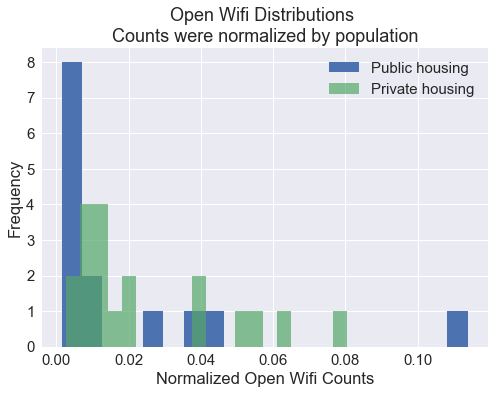

In [572]:
public.norm_open_counts.plot(kind="hist", bins=20, label="Public housing")
private.norm_open_counts.plot(kind="hist", bins=20, label="Private housing", alpha=0.7)
plt.title("Open Wifi Distributions \nCounts were normalized by population")
plt.xlabel("Normalized Open Wifi Counts")
plt.legend()

In [561]:
floors.head(1)

,GEOID,name,MHI,Population,open_net_counts,non_open_net_counts,Public,Public_cat,mean_floors,Open Wifi,Closed Wifi,log_norm_open_counts,log_norm_non_open_counts,log_MHI
0,360470085001,Public_RedHook,10372,7278,15.0,433.0,True,Public Area,2.0,0.004122,0.118989,-5.491414,-2.128726,9.246865


In [565]:
# private Networks - factoring for building height
public = floors[floors.Public == True]
private = floors[floors.Public == False]
print(scipy.stats.ks_2samp(public["Closed Wifi"],private["Closed Wifi"]))
print(scipy.stats.kruskal(public["Closed Wifi"],private["Closed Wifi"]))

Ks_2sampResult(statistic=0.21052631578947367, pvalue=0.82058302342102862)
KruskalResult(statistic=0.76426360017691763, pvalue=0.38199752465388903)


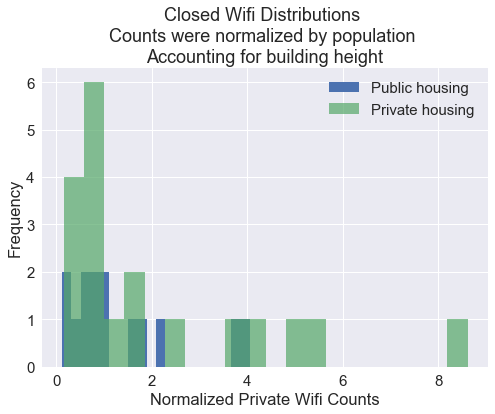

In [570]:
public["Closed Wifi"].plot(kind="hist", bins=20, label="Public housing")
private["Closed Wifi"].plot(kind="hist", bins=20, label="Private housing", alpha=0.7)
plt.title("Closed Wifi Distributions \nCounts were normalized by population \nAccounting for building height")
plt.xlabel("Normalized Private Wifi Counts")
plt.legend()

In [654]:
# private networks
public = scatter_plot[scatter_plot.Public == True]
private = scatter_plot[scatter_plot.Public == False]
scipy.stats.ks_2samp(public.norm_non_open_counts,private.norm_non_open_counts)

Ks_2sampResult(statistic=0.20676691729323307, pvalue=0.8369460996137702)

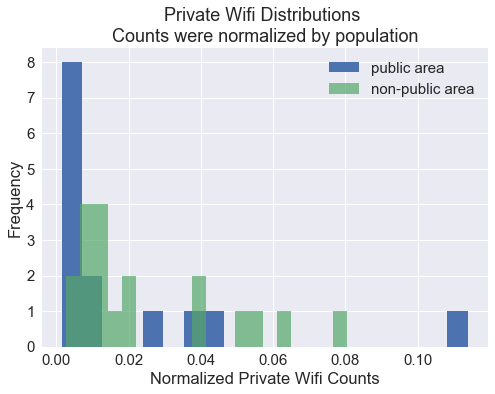

In [655]:
public.norm_open_counts.plot(kind="hist", bins=20, label="public area")
private.norm_open_counts.plot(kind="hist", bins=20, label="non-public area", alpha=0.7)
plt.title("Private Wifi Distributions \nCounts were normalized by population")
plt.xlabel("Normalized Private Wifi Counts")
plt.legend()